In [6]:
!pip install numpy pandas seaborn matplotlib tqdm torch torchvision optuna scikit-learn


## 1. Setup and Imports

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
from collections import OrderedDict

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader, random_split

# Metrics and evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Progress tracking
from tqdm.auto import tqdm

# Hyperparameter optimization
import optuna

# Set matplotlib style
plt.style.use('fivethirtyeight')
sns.set_theme(style="whitegrid")
%matplotlib inline

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seeds for reproducibility
def set_seed(seed=42):
    """Set random seeds for reproducibility across libraries"""
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

Using device: cuda


## 2. Dataset Management

We'll create a `DatasetManager` class to handle dataset loading, preprocessing, and splitting.

In [4]:
class DatasetManager:
    """Handles dataset loading, preprocessing, and splitting for different datasets"""

    def __init__(self, batch_size=128, num_workers=2):
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.datasets = {}
        self.dataloaders = {}

    def load_fashion_mnist(self, data_dir="./data"):
        """Load and prepare the FashionMNIST dataset"""
        # Define transformations
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.2860,), (0.3530,))  # FashionMNIST mean and std
        ])

        # Load datasets
        train_data = datasets.FashionMNIST(
            root=data_dir, train=True, download=True, transform=transform)
        test_data = datasets.FashionMNIST(
            root=data_dir, train=False, download=True, transform=transform)

        # Create validation split
        train_size = int(0.8 * len(train_data))
        val_size = len(train_data) - train_size
        train_dataset, val_dataset = random_split(train_data, [train_size, val_size])

        # Save datasets
        self.datasets['fashion_mnist'] = {
            'train': train_dataset,
            'val': val_dataset,
            'test': test_data,
            'input_shape': (1, 28, 28),
            'num_classes': 10,
            'class_names': ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
        }

        # Create data loaders
        self.dataloaders['fashion_mnist'] = {
            'train': DataLoader(train_dataset, batch_size=self.batch_size,
                               shuffle=True, num_workers=self.num_workers),
            'val': DataLoader(val_dataset, batch_size=self.batch_size,
                             shuffle=False, num_workers=self.num_workers),
            'test': DataLoader(test_data, batch_size=self.batch_size,
                              shuffle=False, num_workers=self.num_workers)
        }

        print(f"FashionMNIST dataset loaded successfully.")
        print(f"Train size: {train_size}, Validation size: {val_size}, Test size: {len(test_data)}")
        return self.datasets['fashion_mnist'], self.dataloaders['fashion_mnist']

    def load_cifar10(self, data_dir="./data"):
        """Load and prepare the CIFAR-10 dataset with data augmentation"""
        # Define transformations - more augmentation for CIFAR-10
        train_transform = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))  # CIFAR-10 mean and std
        ])

        test_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
        ])

        # Load datasets
        train_data = datasets.CIFAR10(
            root=data_dir, train=True, download=True, transform=train_transform)
        test_data = datasets.CIFAR10(
            root=data_dir, train=False, download=True, transform=test_transform)

        # Create validation split
        train_size = int(0.8 * len(train_data))
        val_size = len(train_data) - train_size
        train_dataset, val_dataset = random_split(train_data, [train_size, val_size])

        # Save datasets
        self.datasets['cifar10'] = {
            'train': train_dataset,
            'val': val_dataset,
            'test': test_data,
            'input_shape': (3, 32, 32),
            'num_classes': 10,
            'class_names': ['airplane', 'automobile', 'bird', 'cat', 'deer',
                           'dog', 'frog', 'horse', 'ship', 'truck']
        }

        # Create data loaders
        self.dataloaders['cifar10'] = {
            'train': DataLoader(train_dataset, batch_size=self.batch_size,
                               shuffle=True, num_workers=self.num_workers),
            'val': DataLoader(val_dataset, batch_size=self.batch_size,
                             shuffle=False, num_workers=self.num_workers),
            'test': DataLoader(test_data, batch_size=self.batch_size,
                              shuffle=False, num_workers=self.num_workers)
        }

        print(f"CIFAR-10 dataset loaded successfully.")
        print(f"Train size: {train_size}, Validation size: {val_size}, Test size: {len(test_data)}")
        return self.datasets['cifar10'], self.dataloaders['cifar10']

    def visualize_samples(self, dataset_name, num_samples=10):
        """Visualize random samples from a dataset"""
        if dataset_name not in self.datasets:
            print(f"Dataset {dataset_name} not loaded.")
            return

        dataset_info = self.datasets[dataset_name]
        train_dataset = dataset_info['train']
        class_names = dataset_info['class_names']

        # Get some random samples
        indices = torch.randperm(len(train_dataset))[:num_samples]

        plt.figure(figsize=(15, 8))
        for i, idx in enumerate(indices):
            img, label = train_dataset[idx]
            img = img.permute(1, 2, 0)  # Change from CxHxW to HxWxC

            # If single channel, convert to RGB for display
            if img.shape[2] == 1:
                img = img.repeat(1, 1, 3)

            # Denormalize the image
            if dataset_name == 'fashion_mnist':
                img = img * 0.3530 + 0.2860
            elif dataset_name == 'cifar10':
                mean = torch.tensor([0.4914, 0.4822, 0.4465])
                std = torch.tensor([0.2470, 0.2435, 0.2616])
                img = img * std + mean

            img = torch.clamp(img, 0, 1)

            plt.subplot(2, 5, i+1)
            plt.imshow(img)
            plt.title(f"Class: {class_names[label]}")
            plt.axis('off')

        plt.tight_layout()
        plt.suptitle(f"Random samples from {dataset_name}", y=1.05)
        plt.show()

## 3. Load and explore datasets
Let's load our datasets and visualize some samples to understand what we're working with.

Loading FashionMNIST dataset...
FashionMNIST dataset loaded successfully.
Train size: 48000, Validation size: 12000, Test size: 10000


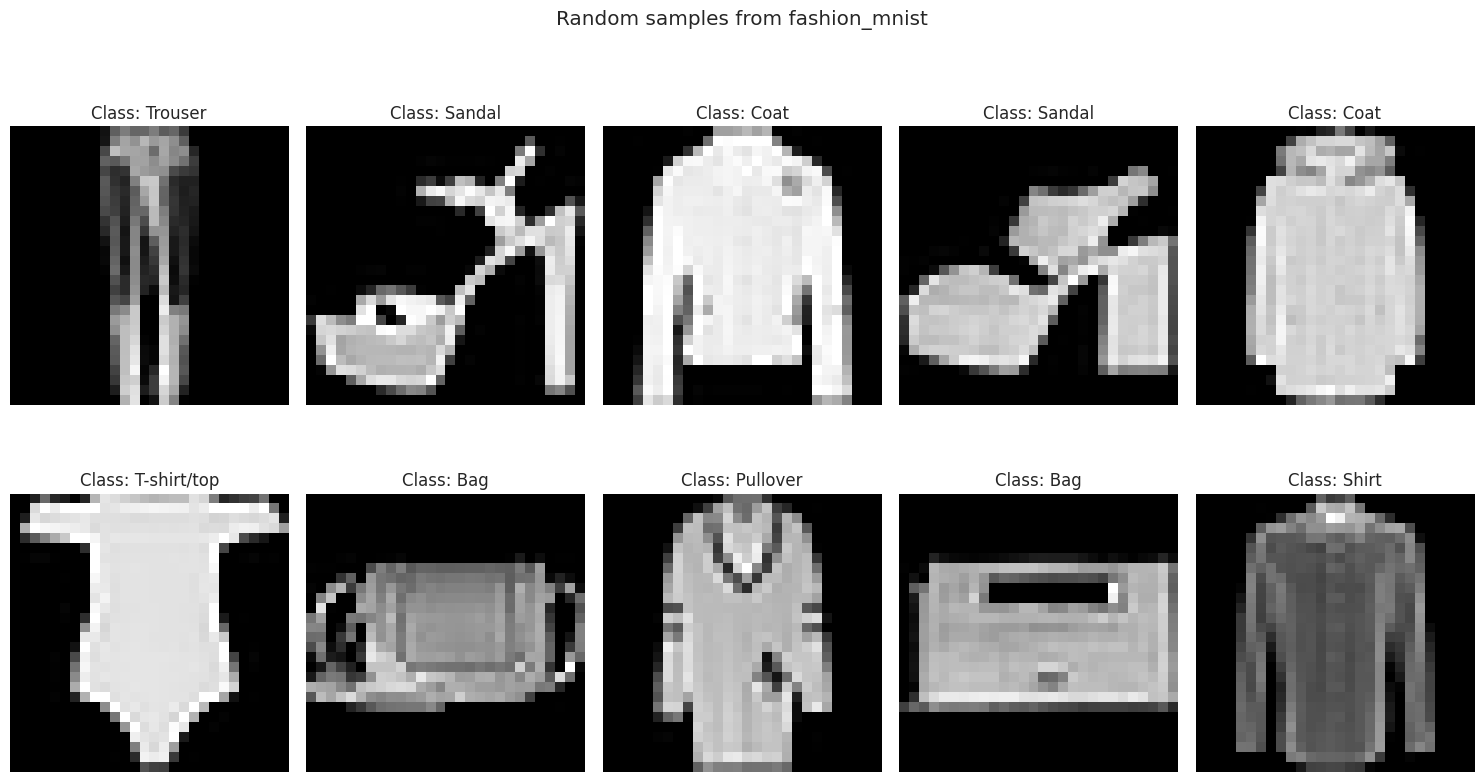


Loading CIFAR-10 dataset...


100%|██████████| 170M/170M [00:01<00:00, 105MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
CIFAR-10 dataset loaded successfully.
Train size: 40000, Validation size: 10000, Test size: 10000


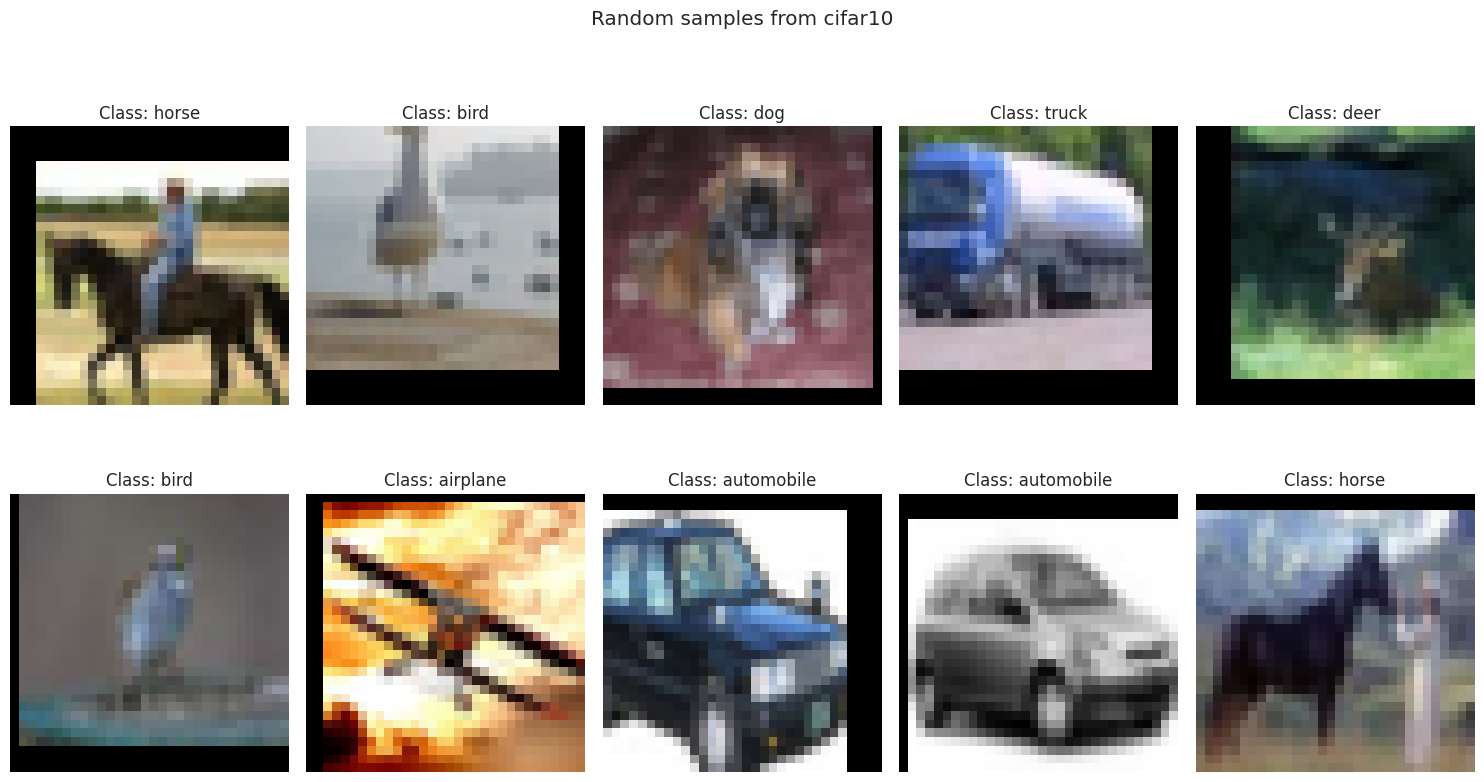

In [5]:
# Initialize data manager
data_manager = DatasetManager(batch_size=128, num_workers=2)

# Load and visualize FashionMNIST
print("Loading FashionMNIST dataset...")
fashion_dataset, fashion_loaders = data_manager.load_fashion_mnist()
data_manager.visualize_samples('fashion_mnist')

# Load and visualize CIFAR-10
print("\nLoading CIFAR-10 dataset...")
cifar_dataset, cifar_loaders = data_manager.load_cifar10()
data_manager.visualize_samples('cifar10')


## 4. Model Architectures
We'll implement three types of models:
 1. Simple fully connected network
 2. Convolutional neural network
 3. ResNet architecture

In [6]:
class Flatten(nn.Module):
    """Flatten layer to convert 2D/3D tensors to 1D"""
    def forward(self, x):
        return x.view(x.size(0), -1)

class SimpleFC(nn.Module):
    """Simple fully connected network for image classification"""
    def __init__(self, input_dim, hidden_dim, num_classes, num_layers=3):
        super().__init__()

        layers = [Flatten()]
        # First layer from input_dim to hidden_dim
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.ReLU())

        # Add hidden layers
        for _ in range(num_layers - 2):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.2))  # Adding dropout for regularization

        # Output layer
        layers.append(nn.Linear(hidden_dim, num_classes))

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

class SimpleCNN(nn.Module):
    """Simple CNN architecture for image classification"""
    def __init__(self, in_channels, num_classes):
        super().__init__()

        # Feature extraction layers
        self.features = nn.Sequential(
            # First conv block
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),

            # Second conv block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),

            # Third conv block (deeper for CIFAR-10)
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),
        )

        # Classifier layers - dynamically calculate input size
        self.avgpool = nn.AdaptiveAvgPool2d((4, 4))  # Adaptive pooling for different input sizes
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = self.classifier(x)
        return x

class ResidualBlock(nn.Module):
    """Basic residual block for ResNet"""
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                              stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                              stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                         stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class SimpleResNet(nn.Module):
    """Simple ResNet architecture for CIFAR-10"""
    def __init__(self, in_channels, num_classes, num_blocks=[2, 2, 2]):
        super().__init__()

        self.in_channels = 64

        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3,
                              stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        # Create ResNet layers
        self.layer1 = self._make_layer(64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(256, num_blocks[2], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(256, num_classes)

    def _make_layer(self, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(ResidualBlock(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

# Factory functions for model creation
def create_model(model_type, input_shape, num_classes, **kwargs):
    """Factory function to create models based on type"""
    if model_type == 'fc':
        input_dim = input_shape[0] * input_shape[1] * input_shape[2]
        hidden_dim = kwargs.get('hidden_dim', 128)
        num_layers = kwargs.get('num_layers', 3)
        return SimpleFC(input_dim, hidden_dim, num_classes, num_layers)

    elif model_type == 'cnn':
        in_channels = input_shape[0]
        return SimpleCNN(in_channels, num_classes)

    elif model_type == 'resnet':
        in_channels = input_shape[0]
        return SimpleResNet(in_channels, num_classes)

    else:
        raise ValueError(f"Unknown model type: {model_type}")

def weight_reset(m):
    """Reset model weights"""
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()


## 5. Create and print model architectures

Let's create our model architectures and print their structures.

In [7]:
# Create models for both datasets
fashion_fc = create_model('fc', fashion_dataset['input_shape'], fashion_dataset['num_classes'])
fashion_cnn = create_model('cnn', fashion_dataset['input_shape'], fashion_dataset['num_classes'])

cifar_cnn = create_model('cnn', cifar_dataset['input_shape'], cifar_dataset['num_classes'])
cifar_resnet = create_model('resnet', cifar_dataset['input_shape'], cifar_dataset['num_classes'])

# Print model architectures
print("Fashion MNIST - Fully Connected Model:")
print(fashion_fc)
print(f"\nTotal parameters: {sum(p.numel() for p in fashion_fc.parameters())}")

print("\n" + "="*50)

print("\nFashion MNIST - CNN Model:")
print(fashion_cnn)
print(f"\nTotal parameters: {sum(p.numel() for p in fashion_cnn.parameters())}")

print("\n" + "="*50)

print("\nCIFAR-10 - ResNet Model:")
print(cifar_resnet)
print(f"\nTotal parameters: {sum(p.numel() for p in cifar_resnet.parameters())}")


Fashion MNIST - Fully Connected Model:
SimpleFC(
  (network): Sequential(
    (0): Flatten()
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=10, bias=True)
  )
)

Total parameters: 118282


Fashion MNIST - CNN Model:
SimpleCNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1,

## 6. Optimization Utilities
Let's define utilities for creating optimizers and learning rate schedulers.


In [8]:
def get_optimizer(optimizer_name, model_params, **kwargs):
    """Factory function to create optimizers"""
    if optimizer_name == 'sgd':
        lr = kwargs.get('lr', 0.01)
        momentum = kwargs.get('momentum', 0.0)
        nesterov = kwargs.get('nesterov', False)
        weight_decay = kwargs.get('weight_decay', 0.0)
        return torch.optim.SGD(model_params, lr=lr, momentum=momentum,
                              nesterov=nesterov, weight_decay=weight_decay)

    elif optimizer_name == 'adam':
        lr = kwargs.get('lr', 0.001)
        weight_decay = kwargs.get('weight_decay', 0.0)
        return torch.optim.Adam(model_params, lr=lr, weight_decay=weight_decay)

    elif optimizer_name == 'adamw':
        lr = kwargs.get('lr', 0.001)
        weight_decay = kwargs.get('weight_decay', 0.01)
        return torch.optim.AdamW(model_params, lr=lr, weight_decay=weight_decay)

    else:
        raise ValueError(f"Unknown optimizer: {optimizer_name}")

def get_scheduler(scheduler_name, optimizer, **kwargs):
    """Factory function to create learning rate schedulers"""
    if scheduler_name == 'step':
        step_size = kwargs.get('step_size', 10)
        gamma = kwargs.get('gamma', 0.1)
        return torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

    elif scheduler_name == 'multistep':
        milestones = kwargs.get('milestones', [30, 60, 90])
        gamma = kwargs.get('gamma', 0.1)
        return torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)

    elif scheduler_name == 'exponential':
        gamma = kwargs.get('gamma', 0.95)
        return torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)

    elif scheduler_name == 'cosine':
        T_max = kwargs.get('T_max', 50)
        eta_min = kwargs.get('eta_min', 0)
        return torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max, eta_min=eta_min)

    elif scheduler_name == 'plateau':
        mode = kwargs.get('mode', 'min')
        factor = kwargs.get('factor', 0.1)
        patience = kwargs.get('patience', 10)
        threshold = kwargs.get('threshold', 1e-4)
        return torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode=mode, factor=factor, patience=patience, threshold=threshold)

    elif scheduler_name is None:
        return None

    else:
        raise ValueError(f"Unknown scheduler: {scheduler_name}")


## 7. Training Utilities

In [9]:
def run_epoch(model, optimizer, dataloader, loss_func, device, results, score_funcs=None, prefix="", desc=""):
    """Run a single epoch of training or evaluation"""
    if score_funcs is None:
        score_funcs = {}

    running_loss = 0.0
    y_true = []
    y_pred = []

    # Use tqdm for progress bar
    progress_bar = tqdm(dataloader, desc=desc, leave=False)

    for inputs, targets in progress_bar:
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = loss_func(outputs, targets)

        # Backward and optimize if in training mode
        if model.training:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Track loss
        running_loss += loss.item() * inputs.size(0)

        # Track predictions for scoring
        _, preds = torch.max(outputs, 1)
        y_true.extend(targets.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

        # Update progress bar
        progress_bar.set_postfix(loss=loss.item())

    # Compute epoch loss
    epoch_loss = running_loss / len(dataloader.dataset)

    # Store results
    if prefix + "loss" not in results:
        results[prefix + "loss"] = []
    results[prefix + "loss"].append(epoch_loss)

    # Compute and store scores
    for score_name, score_func in score_funcs.items():
        if prefix + score_name not in results:
            results[prefix + score_name] = []
        results[prefix + score_name].append(score_func(y_true, y_pred))

    # Return time elapsed for training epochs
    return 0 if not model.training else time.time()

class Trainer:
    """Training manager for PyTorch models"""

    def __init__(self, model, criterion, optimizer, device, scheduler=None,
                 gradient_clipping=None, early_stopping=None, checkpoint_path=None):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        self.scheduler = scheduler
        self.gradient_clipping = gradient_clipping
        self.early_stopping = early_stopping
        self.checkpoint_path = checkpoint_path

        self.history = {
            'train_loss': [], 'train_acc': [],
            'val_loss': [], 'val_acc': [],
            'lr': []
        }

        self.best_val_loss = float('inf')
        self.patience_counter = 0

    def train_epoch(self, train_loader):
        """Train for one epoch"""
        self.model.train()
        running_loss = 0.0
        running_corrects = 0

        # Progress bar for training
        progress_bar = tqdm(train_loader, desc="Training", leave=False)

        for inputs, targets in progress_bar:
            inputs, targets = inputs.to(self.device), targets.to(self.device)

            # Zero the parameter gradients
            self.optimizer.zero_grad()

            # Forward pass
            outputs = self.model(inputs)
            loss = self.criterion(outputs, targets)

            # Backward pass and optimize
            loss.backward()

            # Apply gradient clipping if specified
            if self.gradient_clipping:
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.gradient_clipping)

            self.optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == targets).item()

            # Update progress bar
            progress_bar.set_postfix(loss=loss.item())

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects / len(train_loader.dataset)

        # Save current learning rate
        current_lr = self.optimizer.param_groups[0]['lr']
        self.history['lr'].append(current_lr)

        return epoch_loss, epoch_acc

    def evaluate(self, val_loader, phase="val"):
        """Evaluate the model on validation or test set"""
        self.model.eval()
        running_loss = 0.0
        running_corrects = 0

        all_preds = []
        all_targets = []

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(self.device), targets.to(self.device)

                # Forward pass
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                running_corrects += torch.sum(preds == targets).item()

                # For confusion matrix
                all_preds.extend(preds.cpu().numpy())
                all_targets.extend(targets.cpu().numpy())

        epoch_loss = running_loss / len(val_loader.dataset)
        epoch_acc = running_corrects / len(val_loader.dataset)

        return epoch_loss, epoch_acc, all_preds, all_targets

    def train(self, train_loader, val_loader, epochs):
        """Train the model for a number of epochs"""
        print(f"Starting training for {epochs} epochs...")

        for epoch in range(epochs):
            # Training phase
            train_loss, train_acc = self.train_epoch(train_loader)

            # Validation phase
            val_loss, val_acc, _, _ = self.evaluate(val_loader)

            # Save history
            self.history['train_loss'].append(train_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)

            # Print progress
            print(f"Epoch {epoch+1}/{epochs} - "
                  f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
                  f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, "
                  f"LR: {self.history['lr'][-1]:.6f}")

            # Update learning rate scheduler if using validation loss
            if self.scheduler is not None:
                if isinstance(self.scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                    self.scheduler.step(val_loss)
                else:
                    self.scheduler.step()

            # Check for model improvement
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.patience_counter = 0

                # Save the best model checkpoint
                if self.checkpoint_path:
                    self.save_checkpoint(epoch, val_loss, val_acc)
            else:
                self.patience_counter += 1

            # Early stopping
            if self.early_stopping and self.patience_counter >= self.early_stopping:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break

        print("Training completed!")
        return self.history

    def save_checkpoint(self, epoch, val_loss, val_acc):
        """Save model checkpoint"""
        import os
        os.makedirs(os.path.dirname(self.checkpoint_path), exist_ok=True)

        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'val_loss': val_loss,
            'val_acc': val_acc,
            'history': self.history
        }
        torch.save(checkpoint, self.checkpoint_path)
        print(f"Checkpoint saved to {self.checkpoint_path}")

    def load_checkpoint(self, checkpoint_path=None):
        """Load model from checkpoint"""
        if checkpoint_path is None:
            checkpoint_path = self.checkpoint_path

        if checkpoint_path is None:
            raise ValueError("No checkpoint path provided")

        checkpoint = torch.load(checkpoint_path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.history = checkpoint['history']
        print(f"Checkpoint loaded from {checkpoint_path}")

    def plot_history(self):
        """Plot training history"""
        epochs = range(1, len(self.history['train_loss']) + 1)

        # Plot loss
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.history['train_loss'], 'b-', label='Training Loss')
        plt.plot(epochs, self.history['val_loss'], 'r-', label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        # Plot accuracy
        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.history['train_acc'], 'b-', label='Training Accuracy')
        plt.plot(epochs, self.history['val_acc'], 'r-', label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()

        # Plot learning rate
        plt.figure(figsize=(8, 3))
        plt.plot(epochs, self.history['lr'], 'g-')
        plt.title('Learning Rate')
        plt.xlabel('Epochs')
        plt.ylabel('Learning Rate')
        plt.yscale('log')
        plt.tight_layout()
        plt.show()

## 8. Visualization and Analysis Functions

In [10]:
def plot_confusion_matrix(cm, class_names):
    """Plot confusion matrix heatmap"""
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

def visualize_predictions(model, dataset, dataloader, class_names, num_samples=10):
    """Visualize model predictions on random samples"""
    model.eval()
    all_images = []
    all_labels = []
    all_preds = []

    # Get samples from dataloader
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_images.extend(images.cpu())
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

            if len(all_images) >= num_samples:
                break

    # Display random samples
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()

    for i in range(min(num_samples, len(all_images))):
        img = all_images[i].permute(1, 2, 0).cpu().numpy()

        # Convert single channel to RGB if needed
        if img.shape[2] == 1:
            img = np.repeat(img, 3, axis=2)

        # Denormalize image
        if dataset == 'fashion_mnist':
            img = img * 0.3530 + 0.2860
        elif dataset == 'cifar10':
            mean = np.array([0.4914, 0.4822, 0.4465])
            std = np.array([0.2470, 0.2435, 0.2616])
            img = img * std + mean

        img = np.clip(img, 0, 1)

        # Show image with prediction
        axes[i].imshow(img)
        true_label = class_names[all_labels[i]]
        pred_label = class_names[all_preds[i]]
        title_color = 'green' if all_labels[i] == all_preds[i] else 'red'
        axes[i].set_title(f"True: {true_label}\nPred: {pred_label}",
                         color=title_color)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

def analyze_misclassifications(model, dataloader, class_names):
    """Analyze which classes are most commonly confused with each other"""
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    # Get confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Convert counts to percentages
    cm_percent = cm / cm.sum(axis=1, keepdims=True) * 100

    # Find the top confused pairs
    n_classes = len(class_names)
    confusions = []

    for i in range(n_classes):
        for j in range(n_classes):
            if i != j:
                confusions.append({
                    'true': class_names[i],
                    'predicted': class_names[j],
                    'count': cm[i, j],
                    'percent': cm_percent[i, j]
                })

    # Sort by count
    confusions.sort(key=lambda x: x['count'], reverse=True)

    # Display top 10 confusions
    top_confusions = confusions[:10]
    print("\nTop 10 Confused Class Pairs:")
    for i, conf in enumerate(top_confusions):
        print(f"{i+1}. True: {conf['true']}, Predicted: {conf['predicted']}, "
              f"Count: {conf['count']}, Percent: {conf['percent']:.2f}%")

    # Create a heatmap of the confusion matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='YlGnBu',
               xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix (Percentage)')
    plt.tight_layout()
    plt.show()

def compare_experiments(experiments):
    """Compare the results of multiple experiments"""
    # Plot test accuracy comparison
    names = list(experiments.keys())
    test_accs = [exp['test_acc'] for exp in experiments.values()]

    plt.figure(figsize=(12, 6))
    bars = plt.bar(names, test_accs)
    plt.title('Test Accuracy Comparison')
    plt.xlabel('Experiment')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)

    # Add accuracy labels on top of bars
    for bar, acc in zip(bars, test_accs):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                 f'{acc:.4f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    # Plot training curves for all experiments
    plt.figure(figsize=(15, 10))

    # Training loss
    plt.subplot(2, 2, 1)
    for name, exp in experiments.items():
        plt.plot(exp['history']['train_loss'], label=name)
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Validation loss
    plt.subplot(2, 2, 2)
    for name, exp in experiments.items():
        plt.plot(exp['history']['val_loss'], label=name)
    plt.title('Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Training accuracy
    plt.subplot(2, 2, 3)
    for name, exp in experiments.items():
        plt.plot(exp['history']['train_acc'], label=name)
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Validation accuracy
    plt.subplot(2, 2, 4)
    for name, exp in experiments.items():
        plt.plot(exp['history']['val_acc'], label=name)
    plt.title('Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Print comparison table
    results_table = []
    for name, exp in experiments.items():
        final_train_acc = exp['history']['train_acc'][-1]
        final_val_acc = exp['history']['val_acc'][-1]
        results_table.append({
            'Experiment': name,
            'Train Acc': f"{final_train_acc:.4f}",
            'Val Acc': f"{final_val_acc:.4f}",
            'Test Acc': f"{exp['test_acc']:.4f}",
            'Test Loss': f"{exp['test_loss']:.4f}"
        })

    return pd.DataFrame(results_table)

## 9. Experiment Runner

In [11]:
def run_experiment(experiment_name, dataset_name, model_type, hyperparams=None, epochs=5):
    """Run a complete experiment with the specified configuration"""
    print(f"\n{'='*80}")
    print(f"Starting experiment: {experiment_name}")
    print(f"{'='*80}")

    # Get dataset and dataloader
    if dataset_name == 'fashion_mnist':
        dataset = data_manager.datasets['fashion_mnist']
        dataloaders = data_manager.dataloaders['fashion_mnist']
    elif dataset_name == 'cifar10':
        dataset = data_manager.datasets['cifar10']
        dataloaders = data_manager.dataloaders['cifar10']
    else:
        raise ValueError(f"Unknown dataset: {dataset_name}")

    # Set up model parameters
    if hyperparams is None:
        hyperparams = {}

    model_kwargs = {}
    if 'hidden_dim' in hyperparams:
        model_kwargs['hidden_dim'] = hyperparams['hidden_dim']
    if 'num_layers' in hyperparams:
        model_kwargs['num_layers'] = hyperparams['num_layers']

    # Create model
    model = create_model(model_type, dataset['input_shape'], dataset['num_classes'], **model_kwargs)
    model.to(device)

    # Print model architecture
    print(f"\nModel Architecture: {model_type.upper()}")
    print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters())}")

    # Set up optimizer
    optimizer_name = hyperparams.get('optimizer', 'adamw')
    lr = hyperparams.get('lr', 0.001)
    momentum = hyperparams.get('momentum', 0.9)
    nesterov = hyperparams.get('nesterov', True)
    weight_decay = hyperparams.get('weight_decay', 0.01)

    optimizer_kwargs = {
        'lr': lr,
        'weight_decay': weight_decay
    }

    if optimizer_name == 'sgd':
        optimizer_kwargs['momentum'] = momentum
        optimizer_kwargs['nesterov'] = nesterov

    optimizer = get_optimizer(optimizer_name, model.parameters(), **optimizer_kwargs)

    # Set up learning rate scheduler
    scheduler_name = hyperparams.get('scheduler', 'cosine')
    scheduler_kwargs = {}

    if scheduler_name == 'step':
        scheduler_kwargs['step_size'] = hyperparams.get('step_size', 10)
        scheduler_kwargs['gamma'] = hyperparams.get('gamma', 0.1)
    elif scheduler_name == 'exponential':
        scheduler_kwargs['gamma'] = hyperparams.get('gamma', 0.95)
    elif scheduler_name == 'cosine':
        scheduler_kwargs['T_max'] = hyperparams.get('T_max', epochs//2)
        scheduler_kwargs['eta_min'] = hyperparams.get('eta_min', 1e-6)
    elif scheduler_name == 'plateau':
        scheduler_kwargs['mode'] = 'min'
        scheduler_kwargs['factor'] = hyperparams.get('factor', 0.1)
        scheduler_kwargs['patience'] = hyperparams.get('patience', 5)
        scheduler_kwargs['threshold'] = hyperparams.get('threshold', 1e-4)

    scheduler = get_scheduler(scheduler_name, optimizer, **scheduler_kwargs) if scheduler_name else None

    # Set up trainer
    gradient_clipping = hyperparams.get('gradient_clipping', None)
    early_stopping = hyperparams.get('early_stopping', 10)

    # Create checkpoint directory if it doesn't exist
    import os
    os.makedirs('checkpoints', exist_ok=True)
    checkpoint_path = f"checkpoints/{experiment_name}.pt"

    criterion = nn.CrossEntropyLoss()
    trainer = Trainer(
        model=model,
        criterion=criterion,
        optimizer=optimizer,
        device=device,
        scheduler=scheduler,
        gradient_clipping=gradient_clipping,
        early_stopping=early_stopping,
        checkpoint_path=checkpoint_path
    )

    # Train model
    history = trainer.train(dataloaders['train'], dataloaders['val'], epochs)

    # Plot training history
    trainer.plot_history()

    # Load best model and evaluate on test set
    try:
        trainer.load_checkpoint()
    except:
        print("No checkpoint found, using current model state.")

    test_loss, test_acc, test_preds, test_targets = trainer.evaluate(dataloaders['test'], phase="test")
    print(f"\nTest Results:")
    print(f"  Loss: {test_loss:.4f}")
    print(f"  Accuracy: {test_acc:.4f}")

    # Plot confusion matrix
    cm = confusion_matrix(test_targets, test_preds)
    plot_confusion_matrix(cm, dataset['class_names'])

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(test_targets, test_preds, target_names=dataset['class_names']))

    # Visualize some predictions
    visualize_predictions(
        model=model,
        dataset=dataset_name,
        dataloader=dataloaders['test'],
        class_names=dataset['class_names'],
        num_samples=10
    )

    return {
        'model': model,
        'trainer': trainer,
        'history': history,
        'test_acc': test_acc,
        'test_loss': test_loss
    }


## 8. FashionMNIST Experiments
 Let's run experiments on FashionMNIST with different optimization strategies.



Starting experiment: fashion_mnist_fc_sgd

Model Architecture: FC

Total parameters: 118282
Starting training for 5 epochs...


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 1/5 - Train Loss: 0.6877, Train Acc: 0.7561, Val Loss: 0.4653, Val Acc: 0.8397, LR: 0.010000
Checkpoint saved to checkpoints/fashion_mnist_fc_sgd.pt


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 2/5 - Train Loss: 0.4590, Train Acc: 0.8380, Val Loss: 0.4303, Val Acc: 0.8486, LR: 0.010000
Checkpoint saved to checkpoints/fashion_mnist_fc_sgd.pt


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 3/5 - Train Loss: 0.4299, Train Acc: 0.8485, Val Loss: 0.4197, Val Acc: 0.8483, LR: 0.010000
Checkpoint saved to checkpoints/fashion_mnist_fc_sgd.pt


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 4/5 - Train Loss: 0.4159, Train Acc: 0.8538, Val Loss: 0.4151, Val Acc: 0.8542, LR: 0.010000
Checkpoint saved to checkpoints/fashion_mnist_fc_sgd.pt


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 5/5 - Train Loss: 0.4050, Train Acc: 0.8576, Val Loss: 0.4014, Val Acc: 0.8612, LR: 0.010000
Checkpoint saved to checkpoints/fashion_mnist_fc_sgd.pt
Training completed!


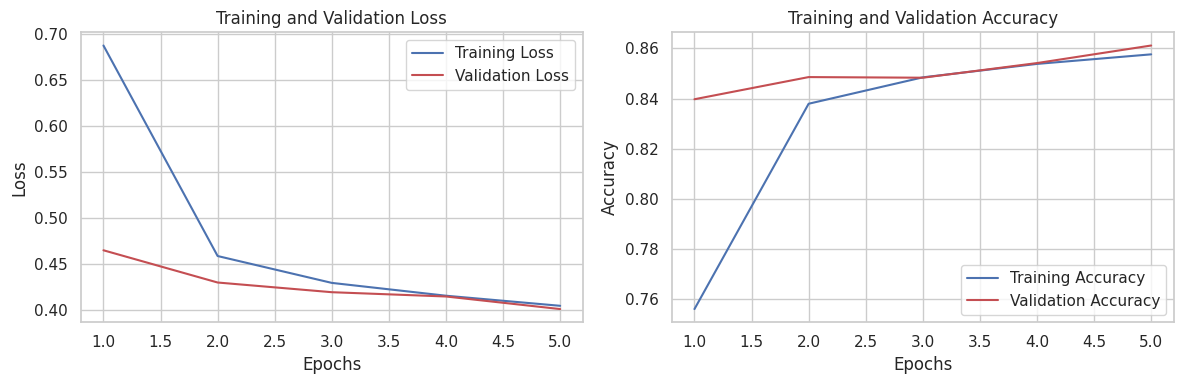

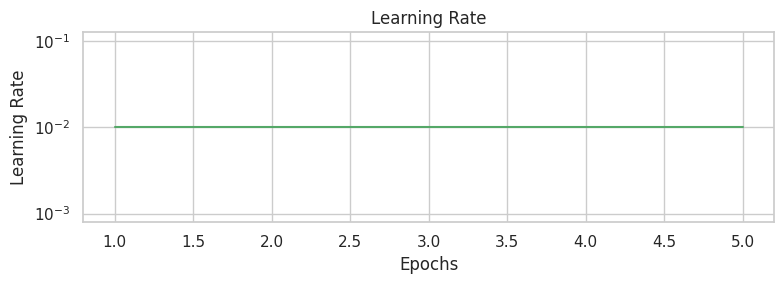

Checkpoint loaded from checkpoints/fashion_mnist_fc_sgd.pt


<ipython-input-9-a8b3e9a2ad23>:226: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)



Test Results:
  Loss: 0.4221
  Accuracy: 0.8494


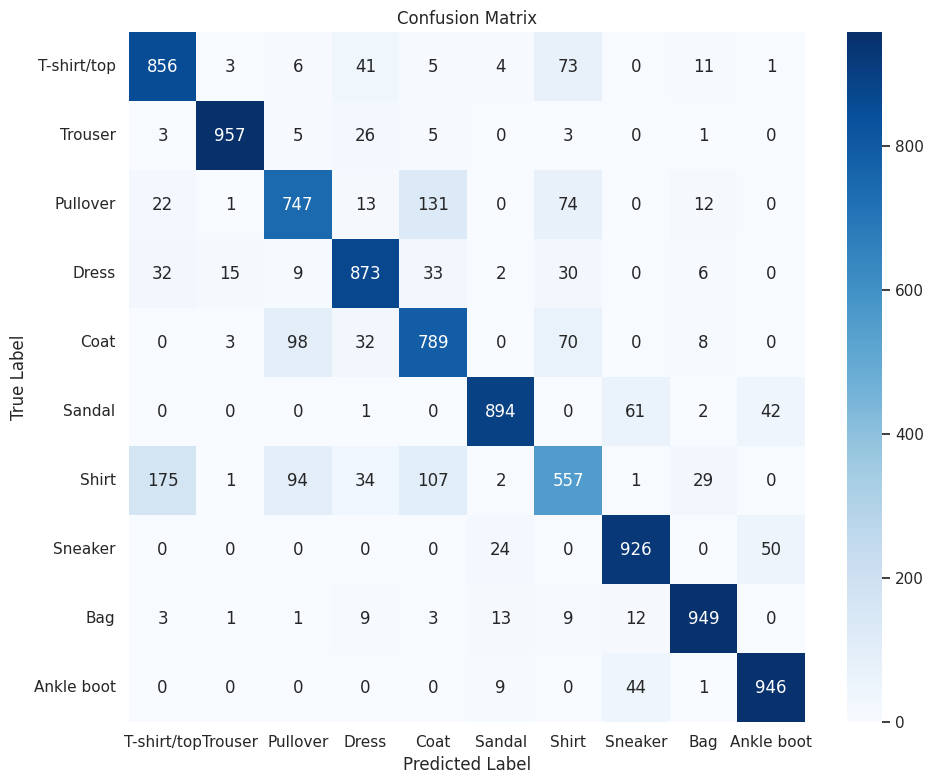


Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.78      0.86      0.82      1000
     Trouser       0.98      0.96      0.97      1000
    Pullover       0.78      0.75      0.76      1000
       Dress       0.85      0.87      0.86      1000
        Coat       0.74      0.79      0.76      1000
      Sandal       0.94      0.89      0.92      1000
       Shirt       0.68      0.56      0.61      1000
     Sneaker       0.89      0.93      0.91      1000
         Bag       0.93      0.95      0.94      1000
  Ankle boot       0.91      0.95      0.93      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



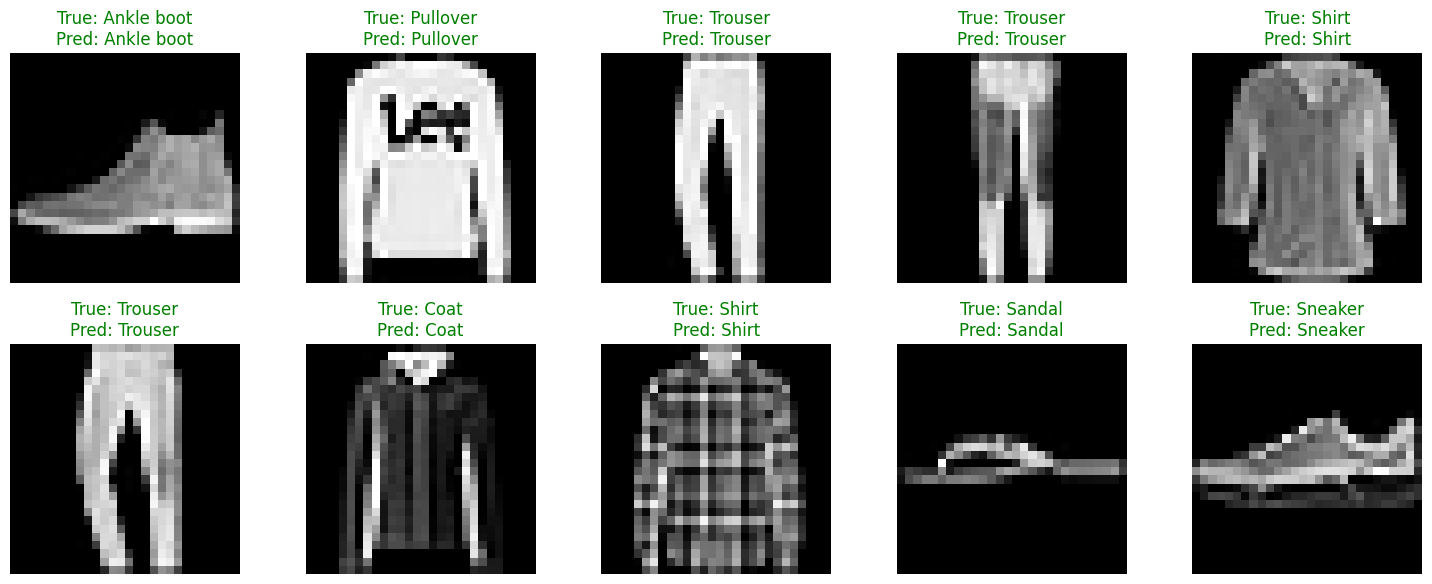

In [12]:
# For demonstration purposes, we'll use a small number of epochs
train_epochs = 5  # In practice, you'd want 20+ epochs

# Experiment 1: Simple FC network with SGD
fc_sgd_params = {
    'optimizer': 'sgd',
    'lr': 0.01,
    'scheduler': None,
    'hidden_dim': 128,
    'num_layers': 3
}

fc_sgd_results = run_experiment(
    experiment_name="fashion_mnist_fc_sgd",
    dataset_name="fashion_mnist",
    model_type="fc",
    hyperparams=fc_sgd_params,
    epochs=train_epochs
)

## Now let's try a different optimization strategy with momentum.


Starting experiment: fashion_mnist_fc_momentum

Model Architecture: FC

Total parameters: 118282
Starting training for 5 epochs...


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 1/5 - Train Loss: 0.6836, Train Acc: 0.7598, Val Loss: 0.4709, Val Acc: 0.8320, LR: 0.010000
Checkpoint saved to checkpoints/fashion_mnist_fc_momentum.pt


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 2/5 - Train Loss: 0.4577, Train Acc: 0.8393, Val Loss: 0.4364, Val Acc: 0.8438, LR: 0.010000
Checkpoint saved to checkpoints/fashion_mnist_fc_momentum.pt


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 3/5 - Train Loss: 0.4196, Train Acc: 0.8515, Val Loss: 0.4185, Val Acc: 0.8515, LR: 0.001000
Checkpoint saved to checkpoints/fashion_mnist_fc_momentum.pt


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c3925c172e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c3925c172e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 15

Epoch 4/5 - Train Loss: 0.4153, Train Acc: 0.8529, Val Loss: 0.4152, Val Acc: 0.8524, LR: 0.001000
Checkpoint saved to checkpoints/fashion_mnist_fc_momentum.pt


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c3925c172e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
Exception ignored in:   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7c3925c172e0>    
if w.is_alive():Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
      self._shutdown_workers()  
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
      if w.is_alive():^
^ ^ ^ ^ ^ ^ ^ ^^^^^^^
^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ ^ ^ ^ ^ 
   File "/usr/lib/

Epoch 5/5 - Train Loss: 0.4108, Train Acc: 0.8562, Val Loss: 0.4140, Val Acc: 0.8537, LR: 0.000100
Checkpoint saved to checkpoints/fashion_mnist_fc_momentum.pt
Training completed!


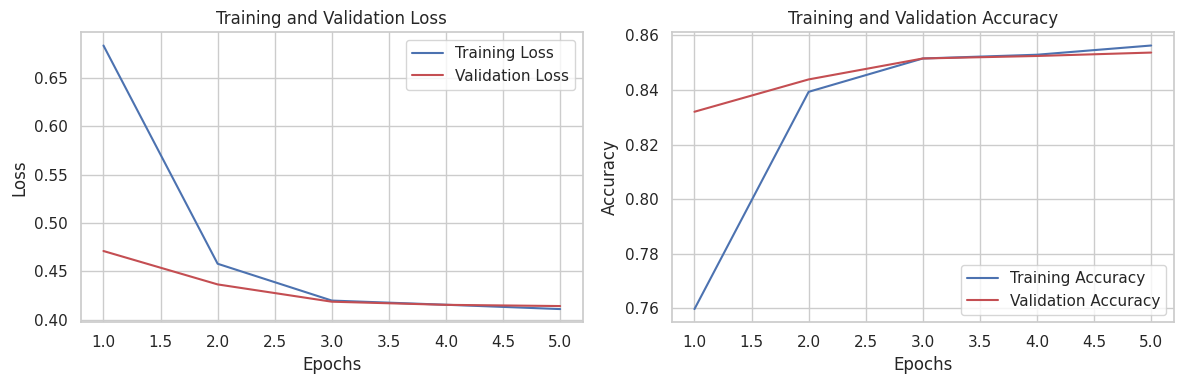

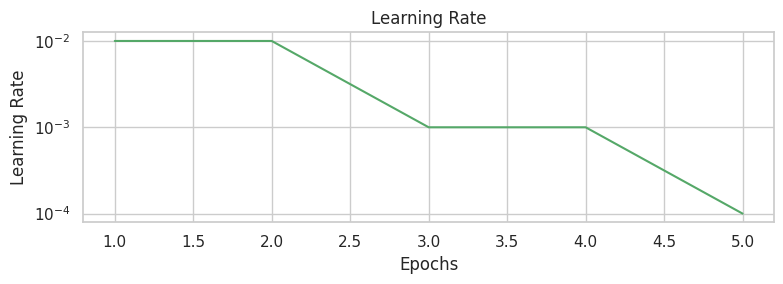

Checkpoint loaded from checkpoints/fashion_mnist_fc_momentum.pt


<ipython-input-9-a8b3e9a2ad23>:226: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)



Test Results:
  Loss: 0.4340
  Accuracy: 0.8428


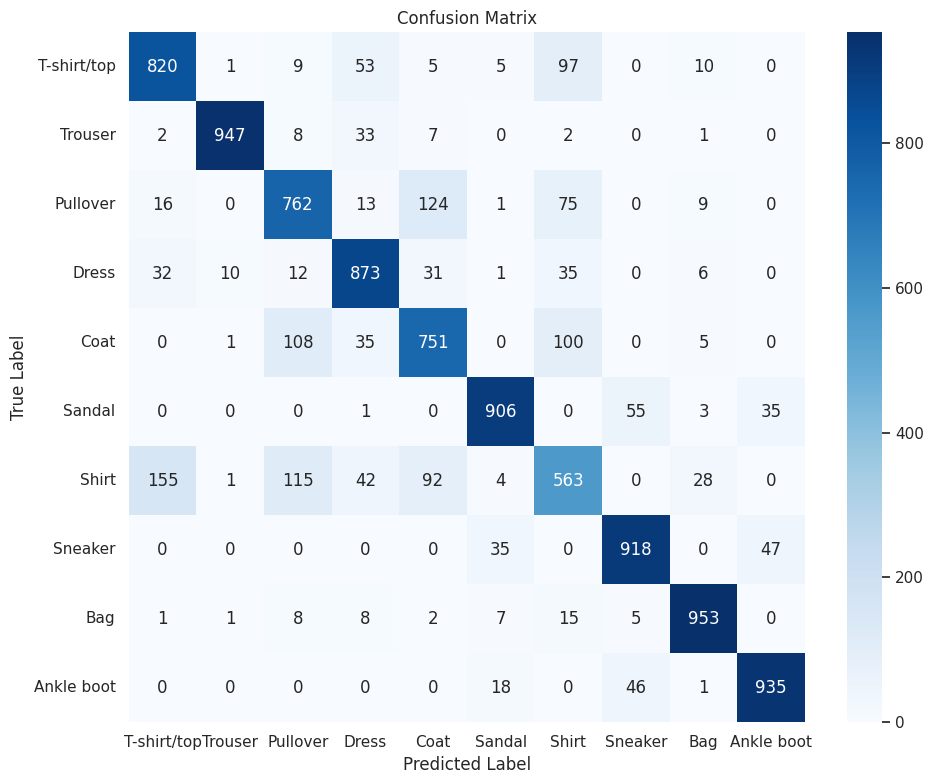


Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.80      0.82      0.81      1000
     Trouser       0.99      0.95      0.97      1000
    Pullover       0.75      0.76      0.75      1000
       Dress       0.83      0.87      0.85      1000
        Coat       0.74      0.75      0.75      1000
      Sandal       0.93      0.91      0.92      1000
       Shirt       0.63      0.56      0.60      1000
     Sneaker       0.90      0.92      0.91      1000
         Bag       0.94      0.95      0.95      1000
  Ankle boot       0.92      0.94      0.93      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



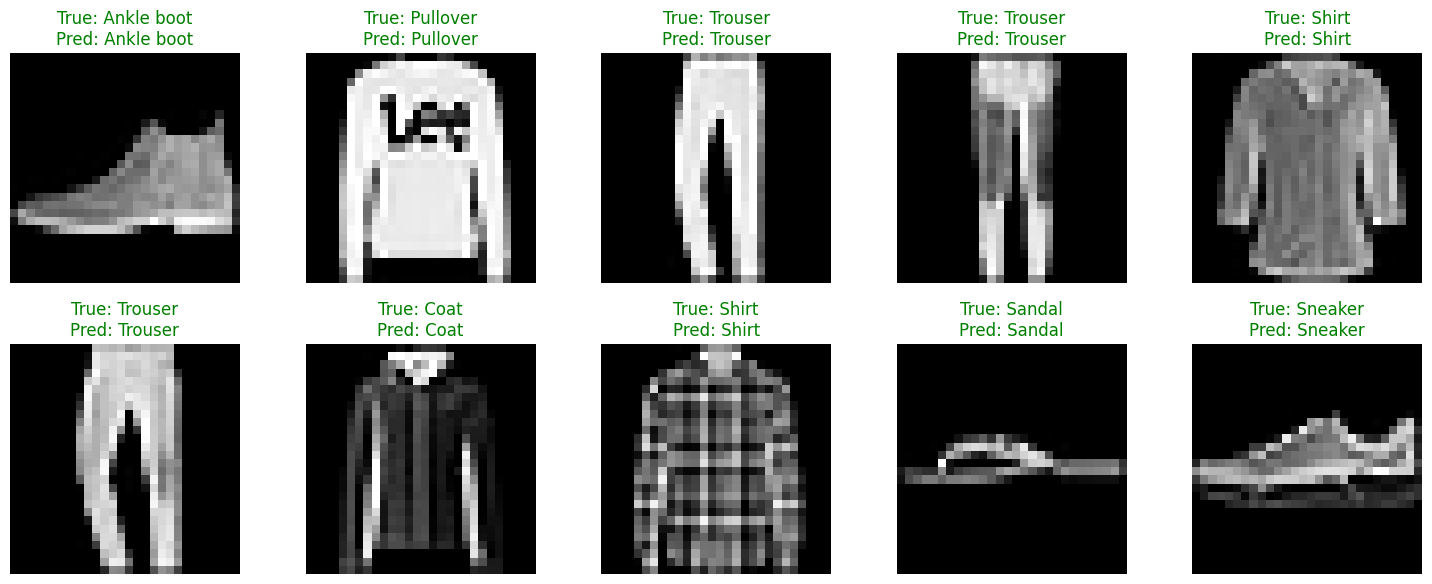

In [13]:
# Experiment 2: Simple FC network with SGD + Momentum
fc_momentum_params = {
    'optimizer': 'sgd',
    'lr': 0.01,
    'momentum': 0.9,
    'nesterov': True,
    'scheduler': 'step',
    'step_size': 2,  # Smaller step size for fewer epochs
    'gamma': 0.1,
    'hidden_dim': 128,
    'num_layers': 3
}

fc_momentum_results = run_experiment(
    experiment_name="fashion_mnist_fc_momentum",
    dataset_name="fashion_mnist",
    model_type="fc",
    hyperparams=fc_momentum_params,
    epochs=train_epochs
)


## Let's try a convolutional network with a more advanced optimizer.


Starting experiment: fashion_mnist_cnn_adam

Model Architecture: CNN

Total parameters: 1341546
Starting training for 5 epochs...


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 1/5 - Train Loss: 0.6138, Train Acc: 0.7758, Val Loss: 0.3648, Val Acc: 0.8638, LR: 0.001000
Checkpoint saved to checkpoints/fashion_mnist_cnn_adam.pt


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 2/5 - Train Loss: 0.3442, Train Acc: 0.8758, Val Loss: 0.2910, Val Acc: 0.8909, LR: 0.000905
Checkpoint saved to checkpoints/fashion_mnist_cnn_adam.pt


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 3/5 - Train Loss: 0.2889, Train Acc: 0.8970, Val Loss: 0.2416, Val Acc: 0.9101, LR: 0.000655
Checkpoint saved to checkpoints/fashion_mnist_cnn_adam.pt


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 4/5 - Train Loss: 0.2506, Train Acc: 0.9092, Val Loss: 0.2285, Val Acc: 0.9165, LR: 0.000346
Checkpoint saved to checkpoints/fashion_mnist_cnn_adam.pt


Training:   0%|          | 0/375 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c3925c172e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7c3925c172e0>^
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
^^    
self._shutdown_workers()  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive

      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
assert self._parent_pid == os.getpid(), 'can only test a child process'    
if w.is_alive():  
               ^ ^^^^^^^^^^^^^^^^^^^^^^
^

Epoch 5/5 - Train Loss: 0.2229, Train Acc: 0.9192, Val Loss: 0.2060, Val Acc: 0.9266, LR: 0.000096
Checkpoint saved to checkpoints/fashion_mnist_cnn_adam.pt
Training completed!


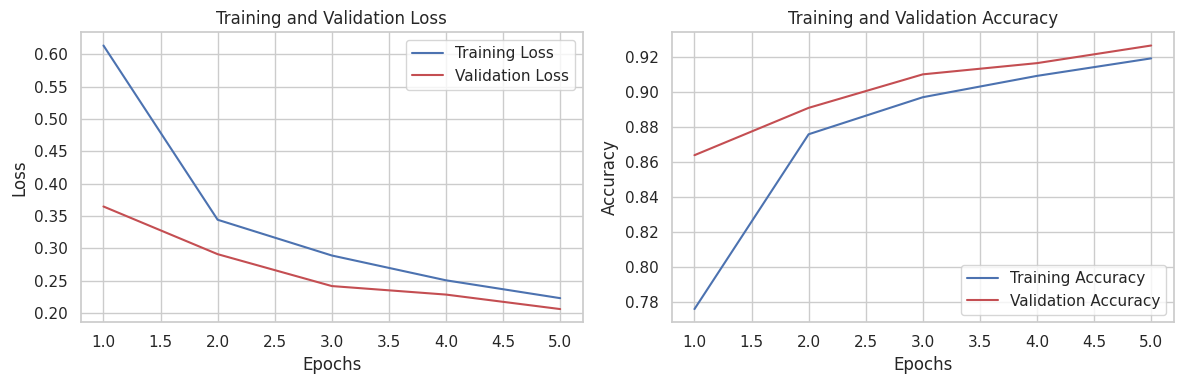

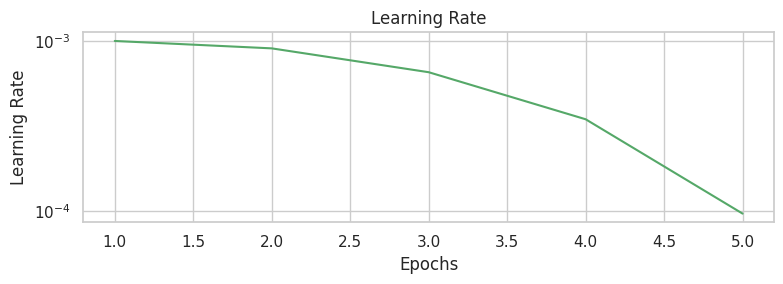

<ipython-input-9-a8b3e9a2ad23>:226: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Checkpoint loaded from checkpoints/fashion_mnist_cnn_adam.pt

Test Results:
  Loss: 0.2175
  Accuracy: 0.9249


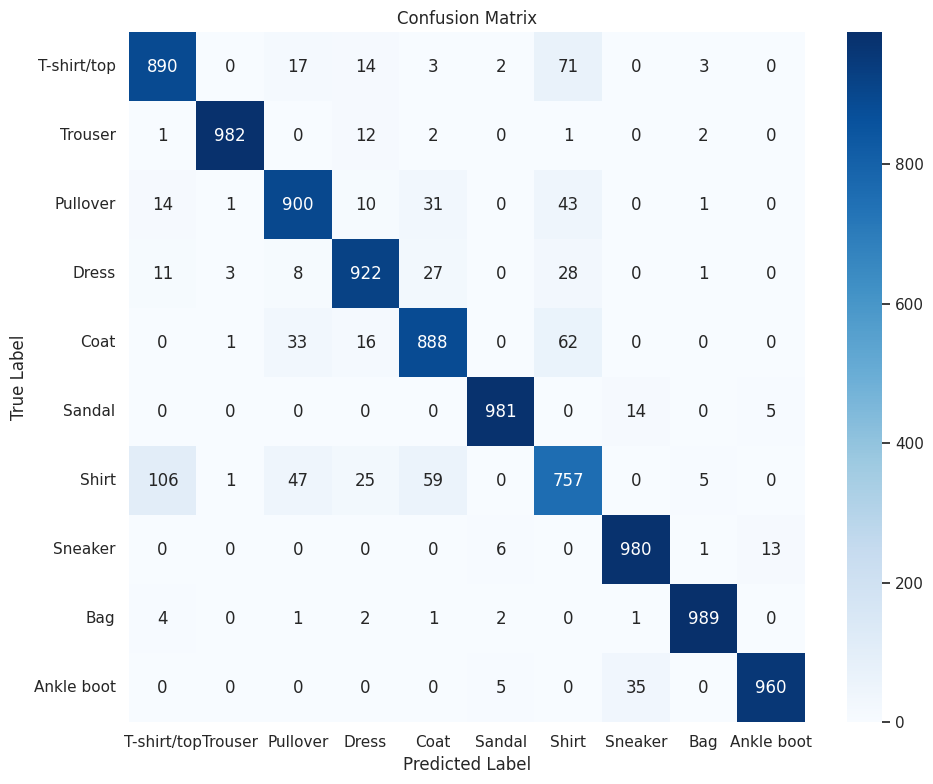


Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.87      0.89      0.88      1000
     Trouser       0.99      0.98      0.99      1000
    Pullover       0.89      0.90      0.90      1000
       Dress       0.92      0.92      0.92      1000
        Coat       0.88      0.89      0.88      1000
      Sandal       0.98      0.98      0.98      1000
       Shirt       0.79      0.76      0.77      1000
     Sneaker       0.95      0.98      0.97      1000
         Bag       0.99      0.99      0.99      1000
  Ankle boot       0.98      0.96      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



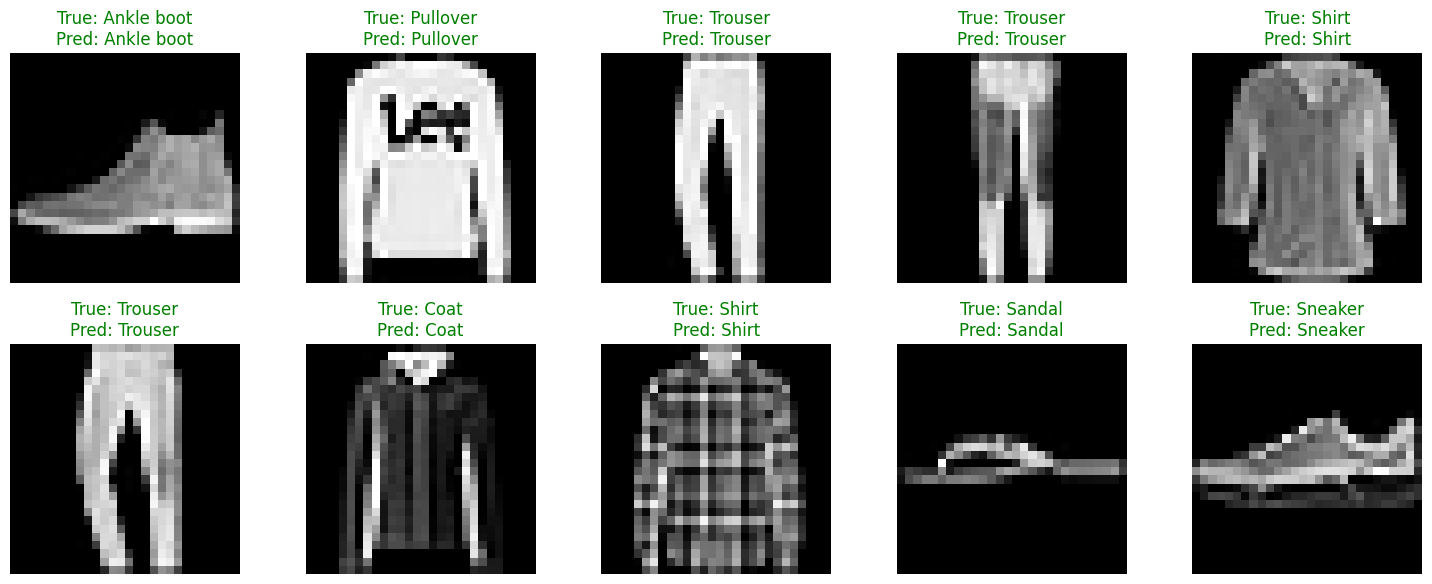

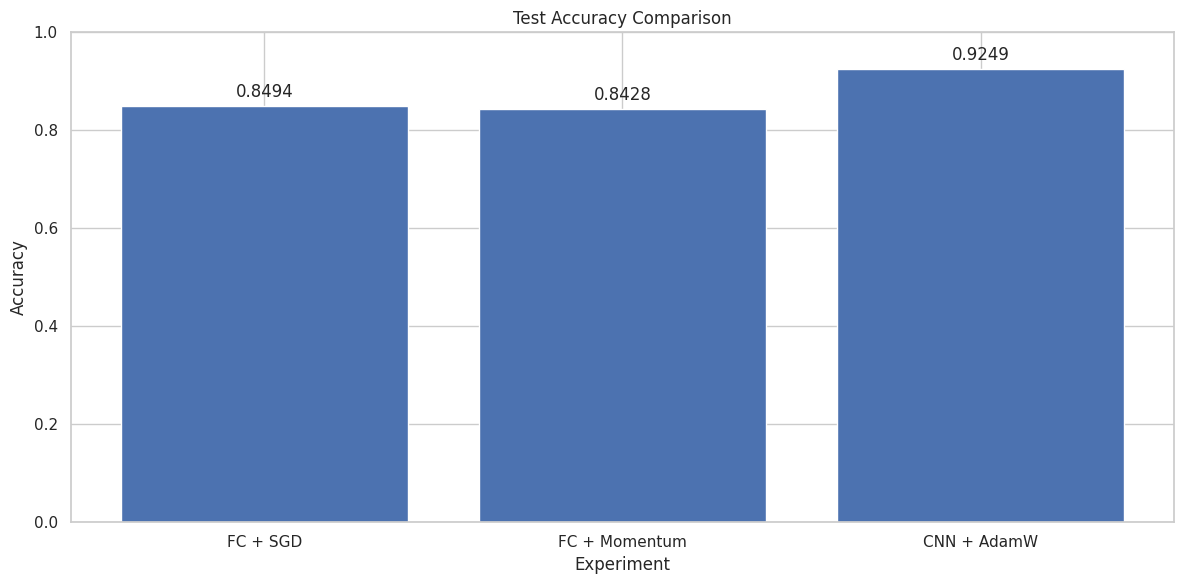

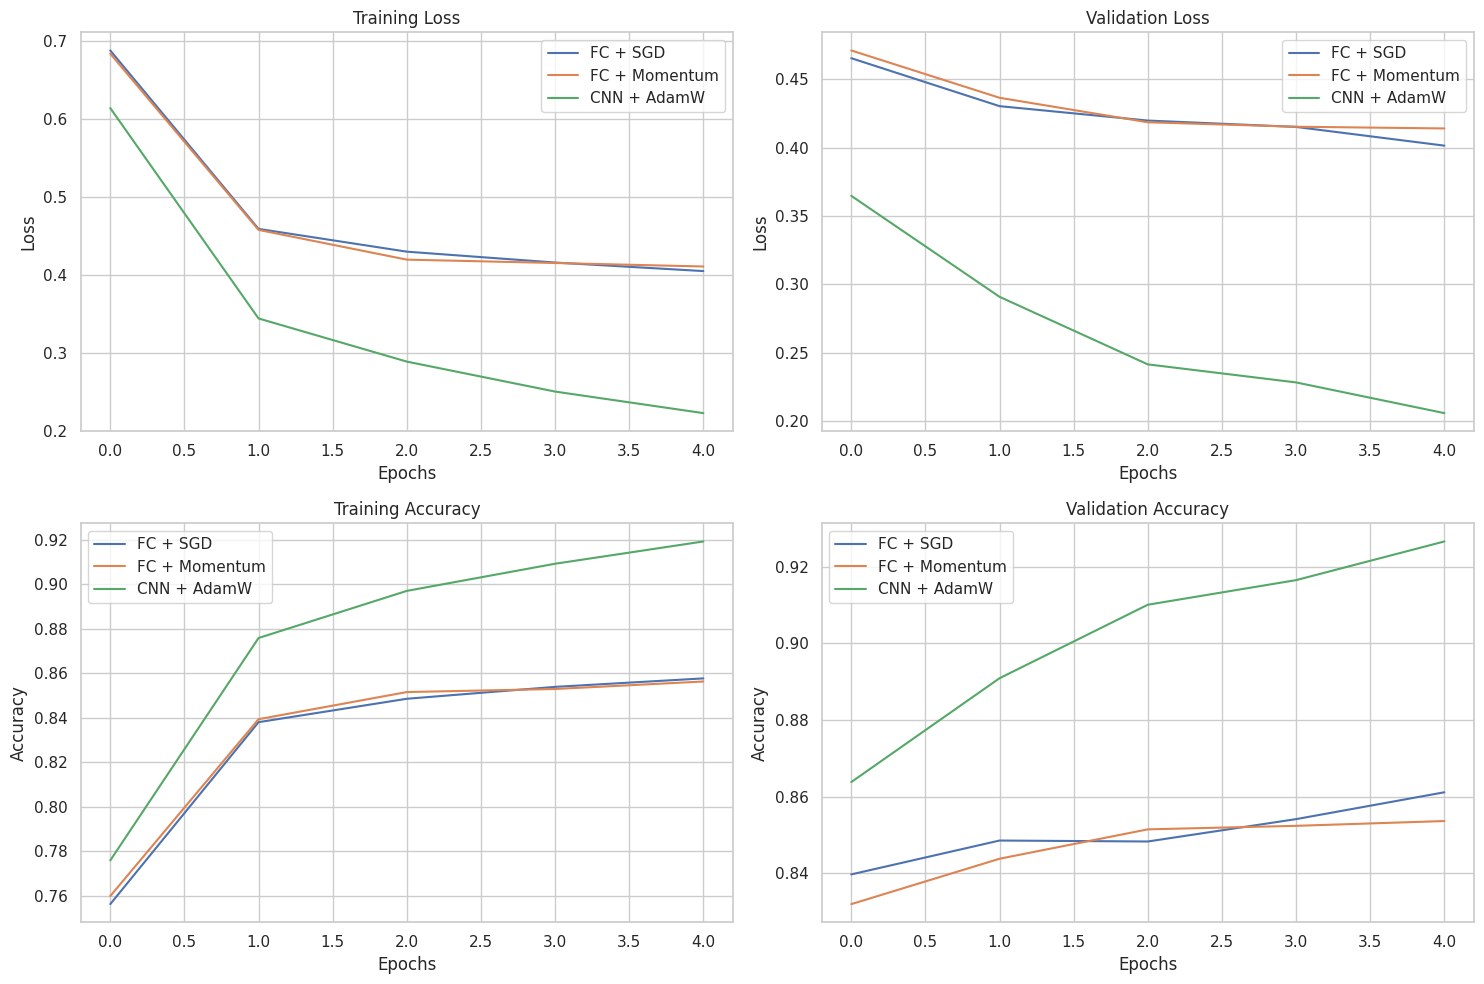


FashionMNIST Experiment Comparison:


,Experiment,Train Acc,Val Acc,Test Acc,Test Loss
0,FC + SGD,0.8576,0.8612,0.8494,0.4221
1,FC + Momentum,0.8562,0.8537,0.8428,0.4340
2,CNN + AdamW,0.9192,0.9266,0.9249,0.2175


In [14]:
# Experiment 3: CNN with AdamW optimizer
cnn_adam_params = {
    'optimizer': 'adamw',
    'lr': 0.001,
    'scheduler': 'cosine',
    'T_max': train_epochs,
    'eta_min': 1e-6
}

cnn_adam_results = run_experiment(
    experiment_name="fashion_mnist_cnn_adam",
    dataset_name="fashion_mnist",
    model_type="cnn",
    hyperparams=cnn_adam_params,
    epochs=train_epochs
)

# Compare FashionMNIST experiments
fashion_experiments = {
    'FC + SGD': fc_sgd_results,
    'FC + Momentum': fc_momentum_results,
    'CNN + AdamW': cnn_adam_results
}

fashion_comparison = compare_experiments(fashion_experiments)
print("\nFashionMNIST Experiment Comparison:")
display(fashion_comparison)


## 10. CIFAR-10 Experiments
 Let's run experiments on CIFAR-10, which is a more challenging dataset.



Starting experiment: cifar10_cnn_adam

Model Architecture: CNN

Total parameters: 1342122
Starting training for 7 epochs...


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 1/7 - Train Loss: 1.6890, Train Acc: 0.3730, Val Loss: 1.5738, Val Acc: 0.4556, LR: 0.001000
Checkpoint saved to checkpoints/cifar10_cnn_adam.pt


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 2/7 - Train Loss: 1.3211, Train Acc: 0.5218, Val Loss: 1.2086, Val Acc: 0.5553, LR: 0.000951
Checkpoint saved to checkpoints/cifar10_cnn_adam.pt


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 3/7 - Train Loss: 1.1360, Train Acc: 0.5963, Val Loss: 1.1043, Val Acc: 0.5961, LR: 0.000812
Checkpoint saved to checkpoints/cifar10_cnn_adam.pt


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 4/7 - Train Loss: 1.0265, Train Acc: 0.6362, Val Loss: 0.9363, Val Acc: 0.6668, LR: 0.000612
Checkpoint saved to checkpoints/cifar10_cnn_adam.pt


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 5/7 - Train Loss: 0.9281, Train Acc: 0.6723, Val Loss: 0.8240, Val Acc: 0.7039, LR: 0.000389
Checkpoint saved to checkpoints/cifar10_cnn_adam.pt


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 6/7 - Train Loss: 0.8625, Train Acc: 0.6952, Val Loss: 0.7629, Val Acc: 0.7291, LR: 0.000189
Checkpoint saved to checkpoints/cifar10_cnn_adam.pt


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c3925c172e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7c3925c172e0> 
 Traceback (most recent call last):
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
       self._shutdown_workers()^
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
^^    ^if w.is_alive():^
^ ^ ^ ^ ^ ^ 
   File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ ^ ^ ^ ^ ^ ^ ^ ^ 
   File "/usr/

Epoch 7/7 - Train Loss: 0.8199, Train Acc: 0.7118, Val Loss: 0.7457, Val Acc: 0.7362, LR: 0.000050
Checkpoint saved to checkpoints/cifar10_cnn_adam.pt
Training completed!


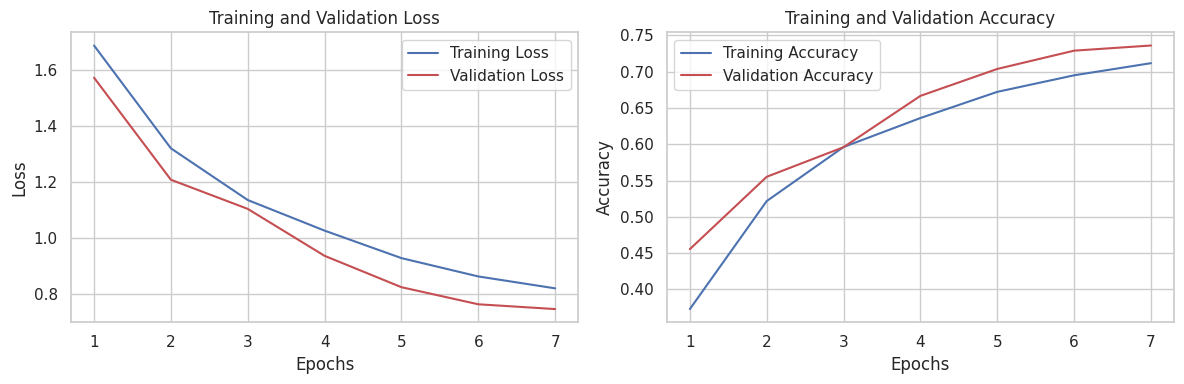

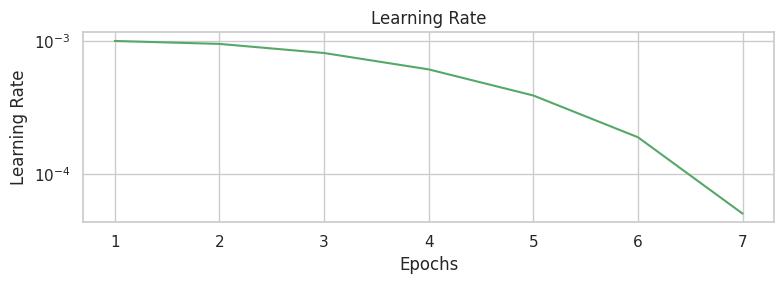

Checkpoint loaded from checkpoints/cifar10_cnn_adam.pt


<ipython-input-9-a8b3e9a2ad23>:226: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)



Test Results:
  Loss: 0.7100
  Accuracy: 0.7489


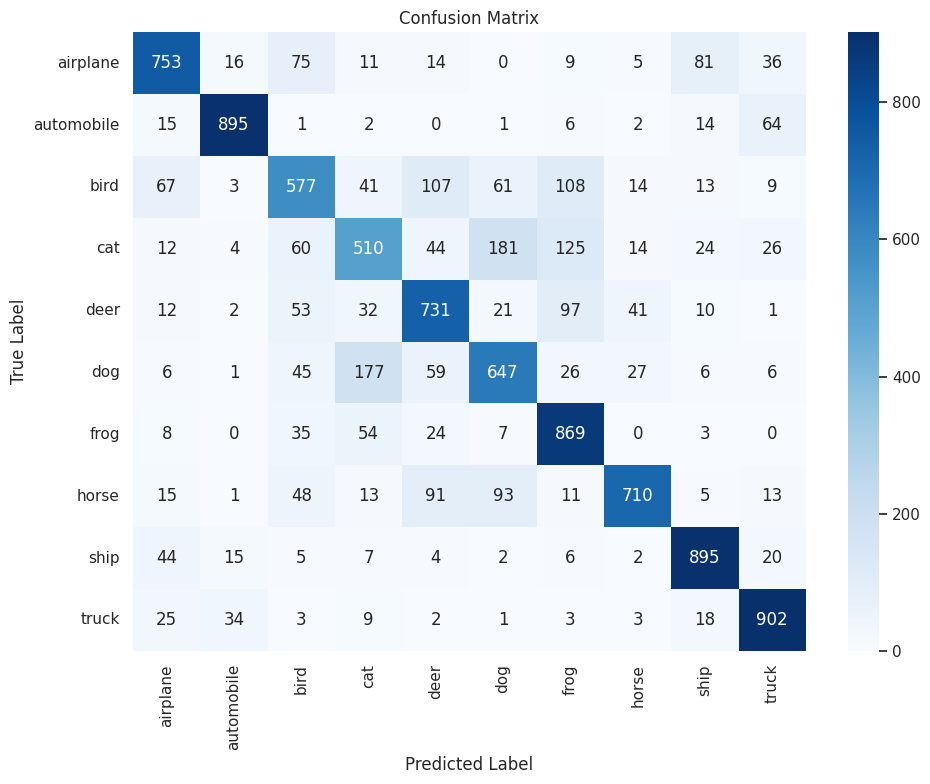


Classification Report:
              precision    recall  f1-score   support

    airplane       0.79      0.75      0.77      1000
  automobile       0.92      0.90      0.91      1000
        bird       0.64      0.58      0.61      1000
         cat       0.60      0.51      0.55      1000
        deer       0.68      0.73      0.70      1000
         dog       0.64      0.65      0.64      1000
        frog       0.69      0.87      0.77      1000
       horse       0.87      0.71      0.78      1000
        ship       0.84      0.90      0.87      1000
       truck       0.84      0.90      0.87      1000

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



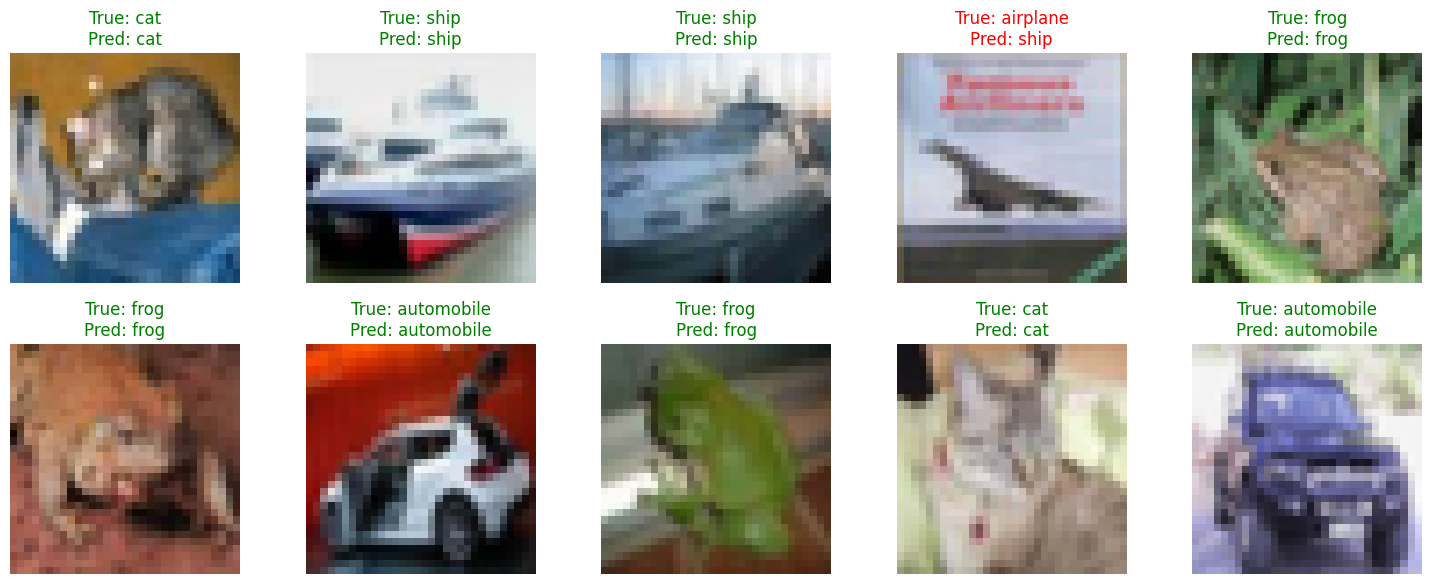

In [15]:
# For CIFAR-10, we'll use slightly more epochs
cifar_epochs = 7  # In practice, you'd want 30+ epochs

# Experiment 1: Simple CNN with AdamW
cnn_cifar_params = {
    'optimizer': 'adamw',
    'lr': 0.001,
    'scheduler': 'cosine',
    'T_max': cifar_epochs,
    'eta_min': 1e-6
}

cnn_cifar_results = run_experiment(
    experiment_name="cifar10_cnn_adam",
    dataset_name="cifar10",
    model_type="cnn",
    hyperparams=cnn_cifar_params,
    epochs=cifar_epochs
)

## Now let's try a more advanced architecture on CIFAR-10.


Starting experiment: cifar10_resnet_adam

Model Architecture: RESNET

Total parameters: 2777674
Starting training for 7 epochs...


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c3925c172e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c3925c172e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 15

Epoch 1/7 - Train Loss: 1.4446, Train Acc: 0.4685, Val Loss: 1.3471, Val Acc: 0.5443, LR: 0.001000
Checkpoint saved to checkpoints/cifar10_resnet_adam.pt


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c3925c172e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7c3925c172e0>  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive

    Traceback (most recent call last):
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__

      self._shutdown_workers() 
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
      if w.is_alive(): 
        ^ ^ ^ ^^^^^^^^^^^^^^^^^^^^^^

Epoch 2/7 - Train Loss: 0.9991, Train Acc: 0.6403, Val Loss: 0.9253, Val Acc: 0.6763, LR: 0.000951
Checkpoint saved to checkpoints/cifar10_resnet_adam.pt


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 3/7 - Train Loss: 0.8095, Train Acc: 0.7134, Val Loss: 0.9794, Val Acc: 0.6665, LR: 0.000812


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 4/7 - Train Loss: 0.6630, Train Acc: 0.7661, Val Loss: 0.8023, Val Acc: 0.7339, LR: 0.000612
Checkpoint saved to checkpoints/cifar10_resnet_adam.pt


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 5/7 - Train Loss: 0.5450, Train Acc: 0.8087, Val Loss: 0.6188, Val Acc: 0.7906, LR: 0.000389
Checkpoint saved to checkpoints/cifar10_resnet_adam.pt


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 6/7 - Train Loss: 0.4584, Train Acc: 0.8409, Val Loss: 0.5066, Val Acc: 0.8286, LR: 0.000189
Checkpoint saved to checkpoints/cifar10_resnet_adam.pt


Training:   0%|          | 0/313 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c3925c172e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c3925c172e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 15

Epoch 7/7 - Train Loss: 0.3985, Train Acc: 0.8637, Val Loss: 0.4663, Val Acc: 0.8455, LR: 0.000050
Checkpoint saved to checkpoints/cifar10_resnet_adam.pt
Training completed!


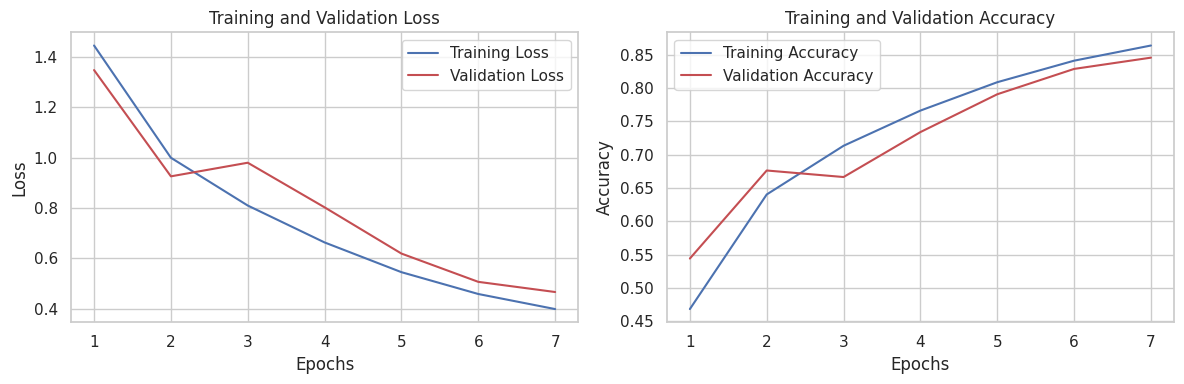

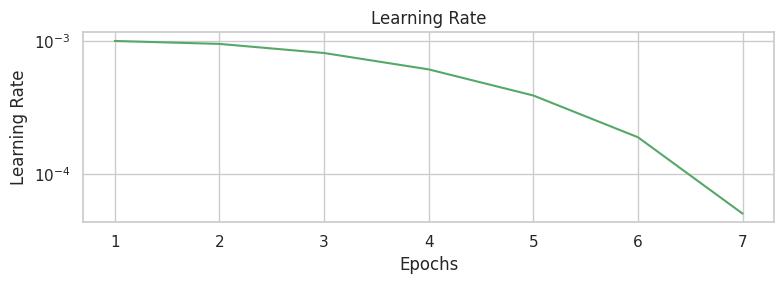

Checkpoint loaded from checkpoints/cifar10_resnet_adam.pt


<ipython-input-9-a8b3e9a2ad23>:226: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)



Test Results:
  Loss: 0.4701
  Accuracy: 0.8448


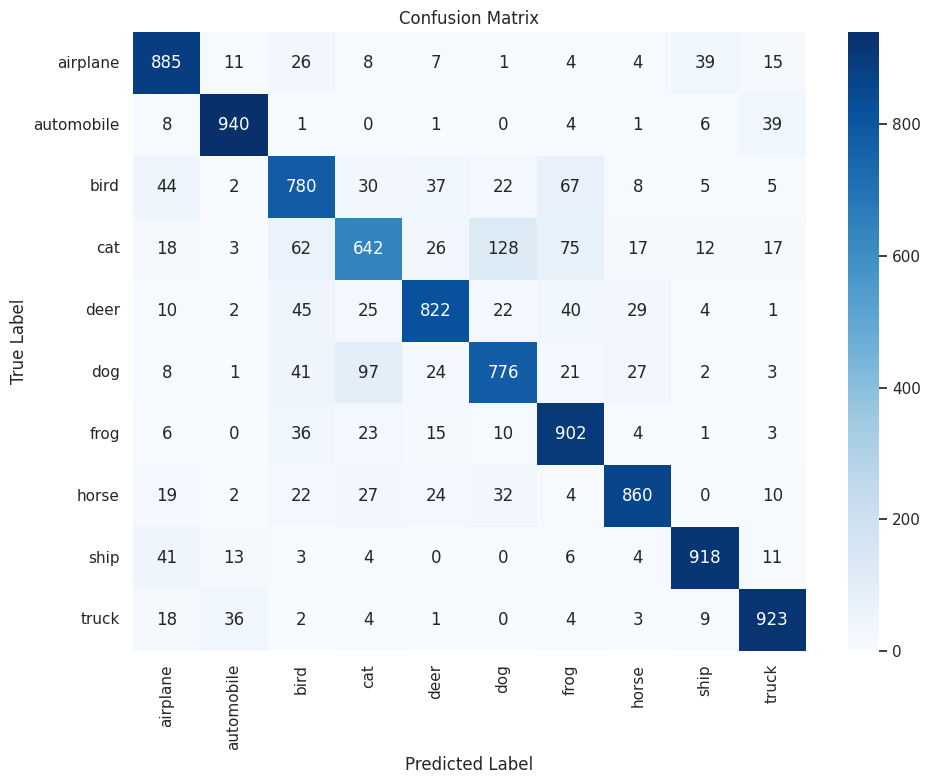


Classification Report:
              precision    recall  f1-score   support

    airplane       0.84      0.89      0.86      1000
  automobile       0.93      0.94      0.94      1000
        bird       0.77      0.78      0.77      1000
         cat       0.75      0.64      0.69      1000
        deer       0.86      0.82      0.84      1000
         dog       0.78      0.78      0.78      1000
        frog       0.80      0.90      0.85      1000
       horse       0.90      0.86      0.88      1000
        ship       0.92      0.92      0.92      1000
       truck       0.90      0.92      0.91      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



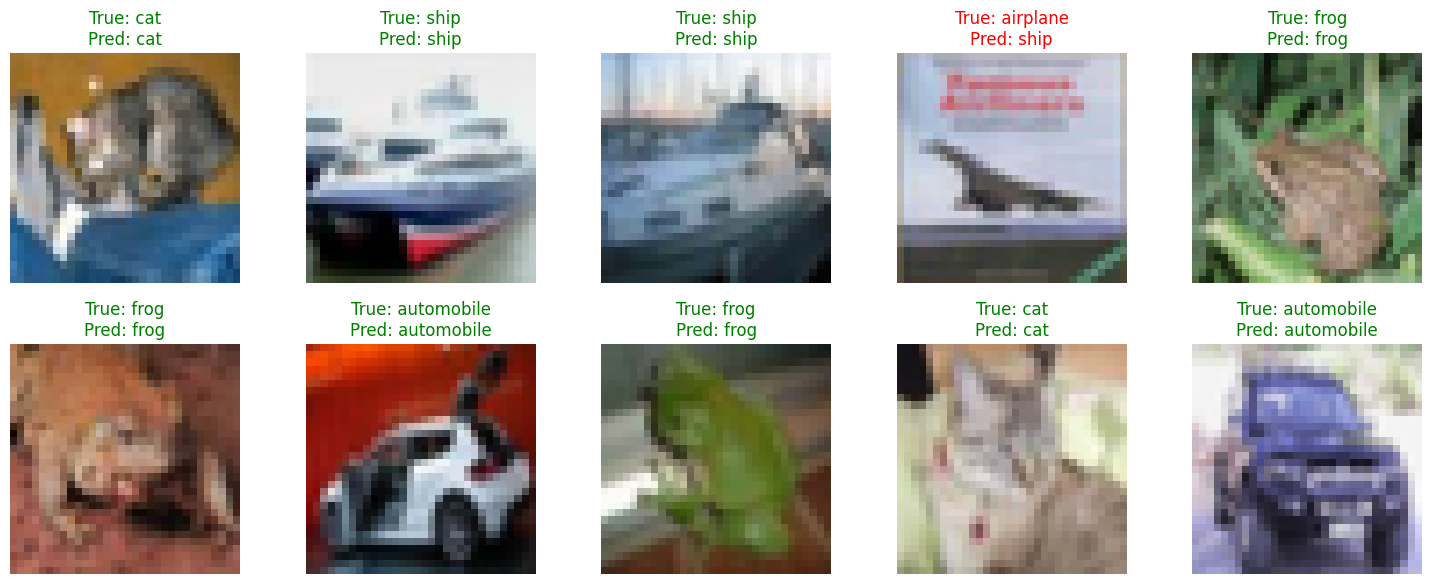

In [16]:
# Experiment 2: ResNet with AdamW + Cosine Scheduler
resnet_cifar_params = {
    'optimizer': 'adamw',
    'lr': 0.001,
    'weight_decay': 0.01,
    'scheduler': 'cosine',
    'T_max': cifar_epochs,
    'eta_min': 1e-6,
    'gradient_clipping': 1.0
}

resnet_cifar_results = run_experiment(
    experiment_name="cifar10_resnet_adam",
    dataset_name="cifar10",
    model_type="resnet",
    hyperparams=resnet_cifar_params,
    epochs=cifar_epochs
)

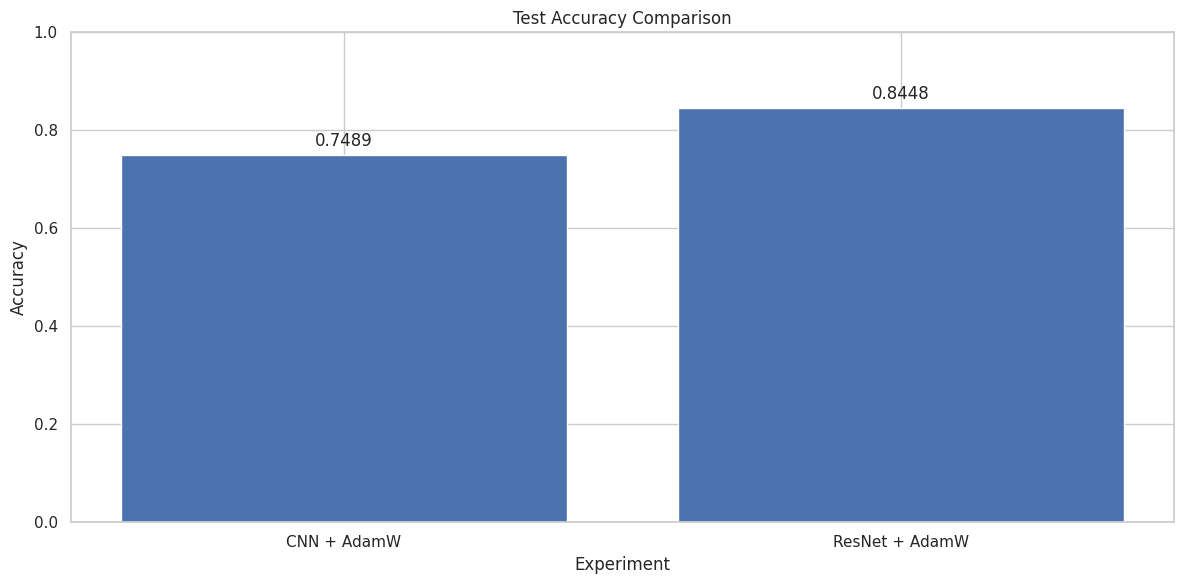

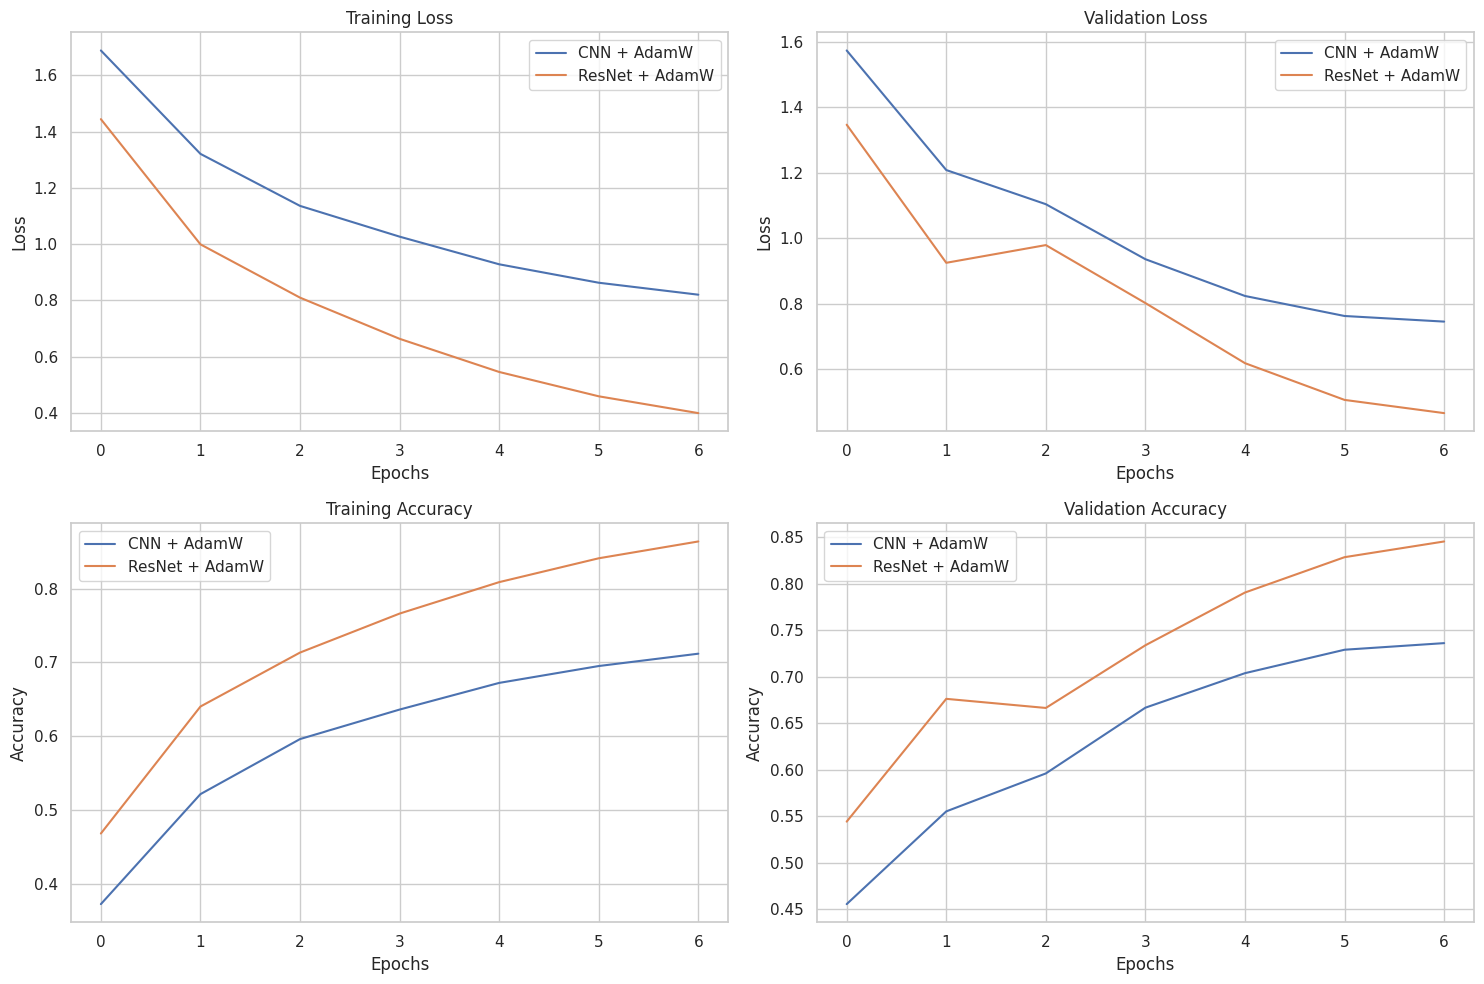


CIFAR-10 Experiment Comparison:


,Experiment,Train Acc,Val Acc,Test Acc,Test Loss
0,CNN + AdamW,0.7118,0.7362,0.7489,0.7100
1,ResNet + AdamW,0.8637,0.8455,0.8448,0.4701


In [17]:
# Compare CIFAR-10 experiments
cifar_experiments = {
    'CNN + AdamW': cnn_cifar_results,
    'ResNet + AdamW': resnet_cifar_results
}

cifar_comparison = compare_experiments(cifar_experiments)
print("\nCIFAR-10 Experiment Comparison:")
display(cifar_comparison)

## 11. Model Analysis and Visualization


Analyzing best CIFAR-10 model: ResNet + AdamW

Analyzing misclassifications:

Top 10 Confused Class Pairs:
1. True: cat, Predicted: dog, Count: 128, Percent: 12.80%
2. True: dog, Predicted: cat, Count: 97, Percent: 9.70%
3. True: cat, Predicted: frog, Count: 75, Percent: 7.50%
4. True: bird, Predicted: frog, Count: 67, Percent: 6.70%
5. True: cat, Predicted: bird, Count: 62, Percent: 6.20%
6. True: deer, Predicted: bird, Count: 45, Percent: 4.50%
7. True: bird, Predicted: airplane, Count: 44, Percent: 4.40%
8. True: dog, Predicted: bird, Count: 41, Percent: 4.10%
9. True: ship, Predicted: airplane, Count: 41, Percent: 4.10%
10. True: deer, Predicted: frog, Count: 40, Percent: 4.00%


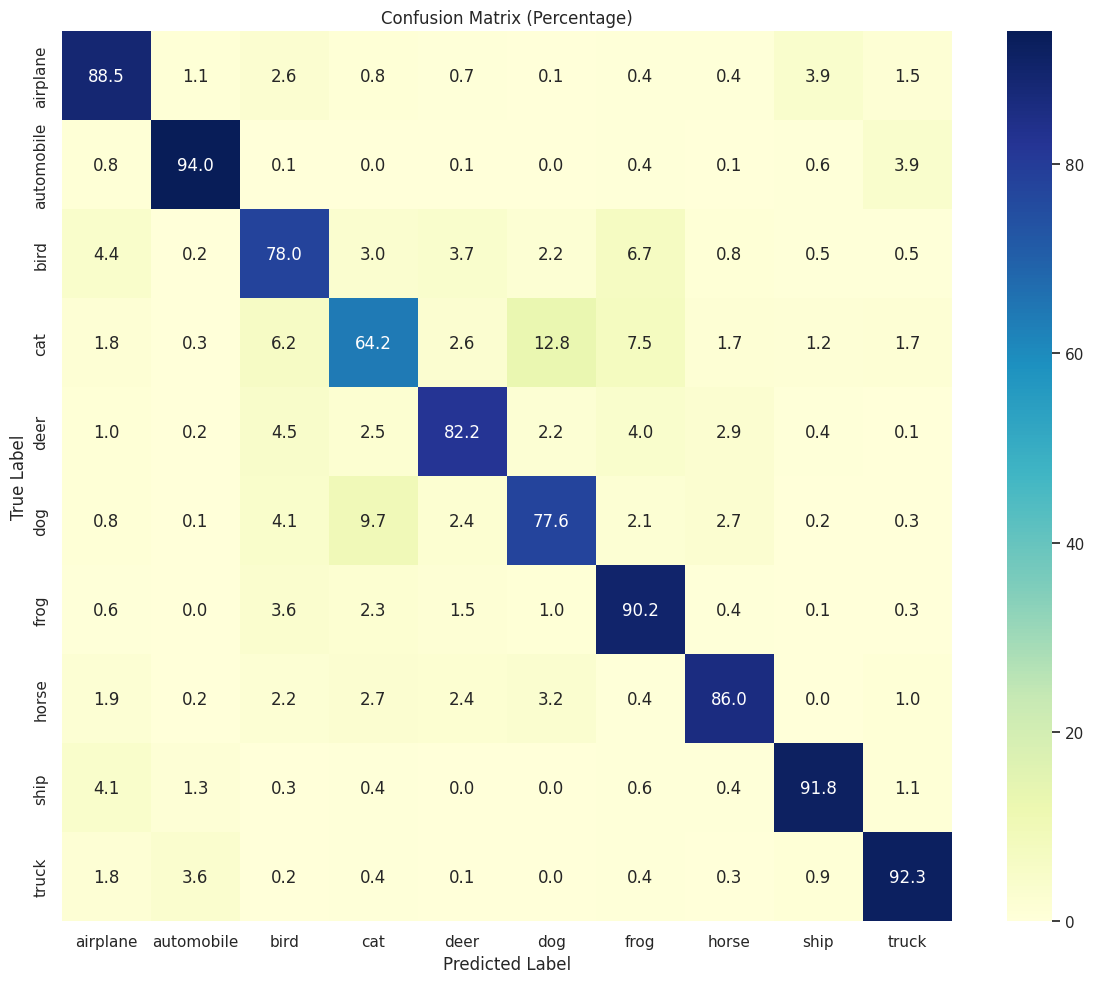

In [18]:
# Analyze the best model from CIFAR-10 experiments
best_model_name = max(cifar_experiments.items(), key=lambda x: x[1]['test_acc'])[0]
best_model = cifar_experiments[best_model_name]['model']

print(f"\nAnalyzing best CIFAR-10 model: {best_model_name}")

# Analyze misclassifications
print("\nAnalyzing misclassifications:")
analyze_misclassifications(
    model=best_model,
    dataloader=cifar_loaders['test'],
    class_names=cifar_dataset['class_names']
)

## Let's analyze the most difficult classes in our best model.

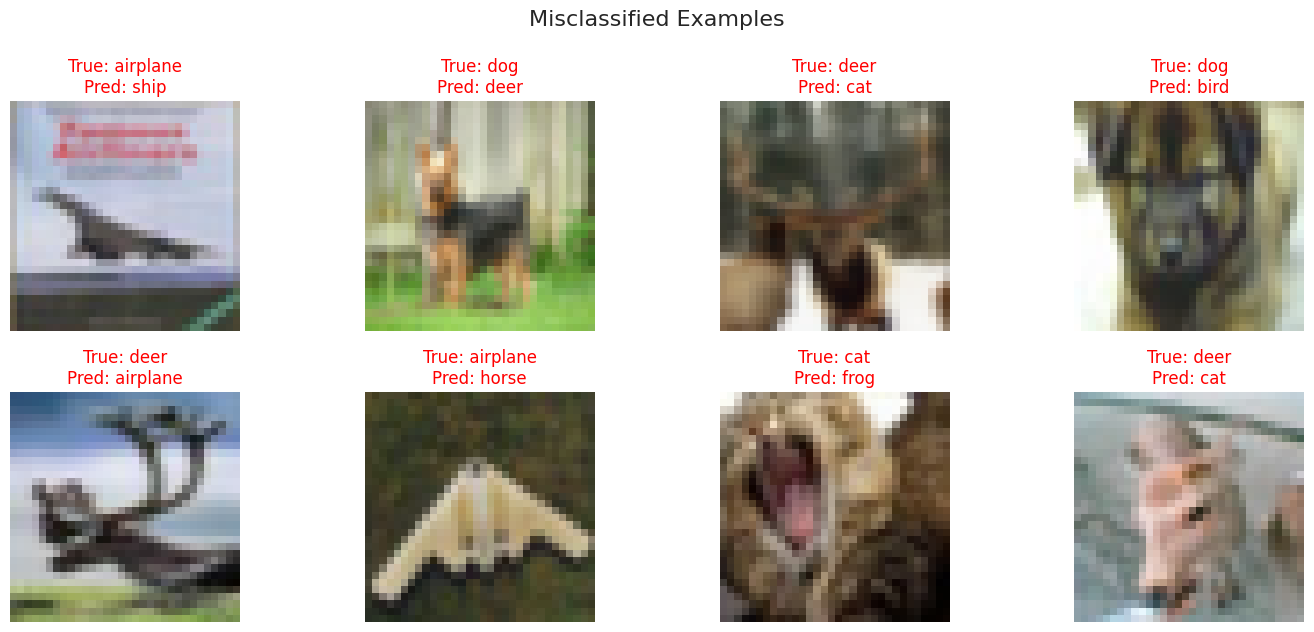

In [19]:
# Load a batch of test images
test_iter = iter(cifar_loaders['test'])
sample_images, sample_labels = next(test_iter)

# Get predictions for these images
best_model.eval()
with torch.no_grad():
    outputs = best_model(sample_images.to(device))
    _, preds = torch.max(outputs, 1)

preds = preds.cpu().numpy()
sample_labels = sample_labels.numpy()
correct = (preds == sample_labels)

# Get the indices of incorrectly classified images
incorrect_indices = np.where(correct == False)[0]

# Show some incorrectly classified images
if len(incorrect_indices) > 0:
    plt.figure(figsize=(15, 6))
    num_images = min(8, len(incorrect_indices))

    for i in range(num_images):
        idx = incorrect_indices[i]
        img = sample_images[idx].permute(1, 2, 0).numpy()

        # Denormalize image
        mean = np.array([0.4914, 0.4822, 0.4465])
        std = np.array([0.2470, 0.2435, 0.2616])
        img = img * std + mean
        img = np.clip(img, 0, 1)

        plt.subplot(2, 4, i+1)
        plt.imshow(img)
        plt.title(f"True: {cifar_dataset['class_names'][sample_labels[idx]]}\n"
                 f"Pred: {cifar_dataset['class_names'][preds[idx]]}", color='red')
        plt.axis('off')

    plt.tight_layout()
    plt.suptitle("Misclassified Examples", y=1.05, fontsize=16)
    plt.show()
else:
    print("No misclassified images in this batch.")
